## Дипломный проект  
## "Модель прогнозирования стоимости жилья для агентства недвижимости"

## Описание данных:
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).



In [343]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import optuna
import pickle

from scipy import stats
from sklearn import linear_model
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

## Знакомство с данными

In [156]:
#Прочитаем наш файл с исходными данными
data = pd.read_csv('data.csv')
data.head()
#display(f'Кол-во строк: {data.shape[0]}, кол-во признаков: {data.shape[1]}.')

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

In [157]:
#посмотрим основную информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Выводы: Представленный датасет содержащий 18 признаков и содержащий более 374 тысяч строк. Все признаки представлены в типе данных - object. В данных содержится большое количество пропусков.

Анализ пропущенных значений


In [158]:
#смотрим пропуски в каждом столбце датасета
null_percent = data.isnull().mean()*100
#столбцы с пропущенными значениями в пересчете на проценты
cols_with_null = null_percent[null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

Визуализируем данные с помощью диаграммы, чтобы визуально оценить процентное соотношение числа пропусков к числу записей в каждом столбце.

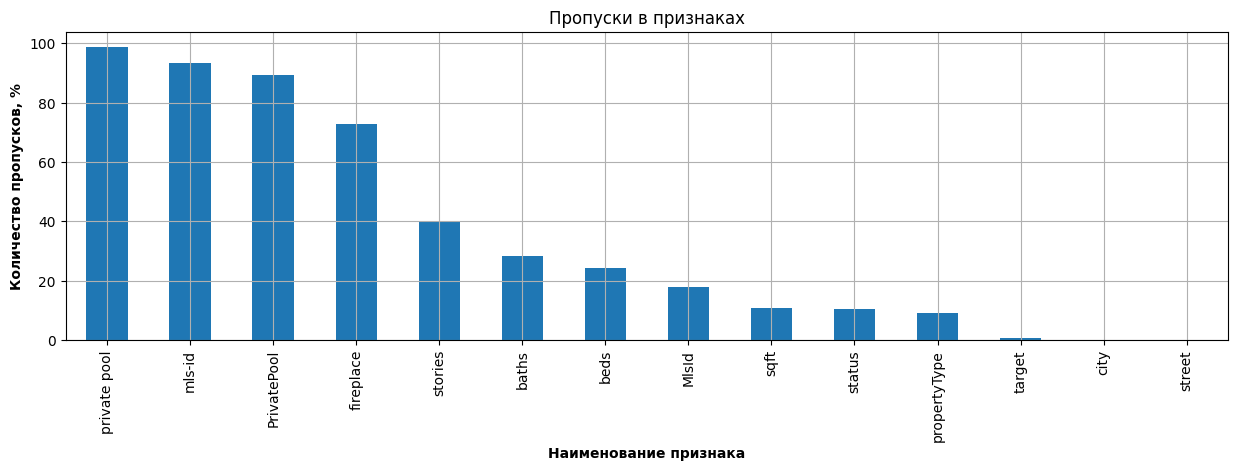

In [159]:
#строим диаграмму пропущенных значений
cols_with_null.plot(
    kind='bar',
    figsize=(15, 4),
    title='Пропуски в признаках',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Количество пропусков, %", fontweight="bold");

Вывод: Мы видем что максимальное количество пропусков содержиться в признаках: private pool, PrivatePool, fireplace, stories 
Остальные признаки содержат менее 40% пропущенных значений.

In [160]:
#удалим признаки 'mls-id' и 'MlsId' так как они предназначены для идентификации объекта в общих базах риэлторов, для нас
#они совершенно не информативны
data = data.drop(['MlsId', 'mls-id'], axis=1)

In [161]:
#проверим наш датасет на наличие дублей
data.duplicated().sum() 

141

In [162]:
#удаляем дубли
data = data.drop_duplicates(ignore_index=True)

Выводы: В нашем датасете были обнаруженны 141 дубль, которые мы удалили.

In [163]:
#Для начала выведем общее количество пропусков в таблице
print(data.isna().sum())

status           39916
private pool    372863
propertyType     34725
street               2
baths           106262
homeFacts            0
fireplace       273933
city                32
schools              0
sqft             40536
zipcode              0
beds             91205
state                0
stories         150583
PrivatePool     336734
target            2480
dtype: int64


In [164]:
#у нас есть два признака 'private pool' и 'PrivatePool', которые повторяються и в них много пропусков.
#Проверим какие значения у данных признаков.
display(data['private pool'].unique())
display(data['PrivatePool'].unique())

array([nan, 'Yes'], dtype=object)

array([nan, 'yes', 'Yes'], dtype=object)

Выводы: Предположительно, что данные признаки дублируют друг друга. Всего представленно три значения nan, 'yes', 'Yes'. 
Значение nan - предположительно это отсутствие бассейна. Объеденим эти два признака и закодируем их 1/0


In [165]:
#объединим признаки PrivatePool и private pool по строчно в один признак pool, если в одном из признаков значение не nan, оно помещается в новый признак
data['pool'] = data[['PrivatePool', 'private pool']].bfill(axis= 1).iloc[:, 0]
print(data['pool'].unique())

[nan 'yes' 'Yes']


In [166]:
#присвоим значение 1, если есть бассейн, в противном случае 0
data['pool'] = data['pool'].apply(lambda x: 1 if x=='Yes' or x=='yes' else 0)
#удалим признаки PrivatePool, private pool
data.drop(['PrivatePool', 'private pool'], axis=1, inplace=True)

In [167]:
#проверем не появились ли дубли после нашего преобразоввания
data.duplicated().sum()


0

Признак status

In [168]:
#посмотрим популярные значения данного признака
data['status'].value_counts()

for sale                156052
Active                  105125
For sale                 43464
foreclosure               6425
New construction          5474
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 159, dtype: int64

Вывод: Мы видем что у нас дублируется значение "For sale" и "for sale", а так же очень близко по морфологическому значению "Active". Предположительно это одно и тоже, поэтому мы объеденим их. Приведем к нижнему регистру потому что нет различия между "For sale"и "for sale".


In [169]:
#приведем к нижнему регистру
data.status = data.status.str.lower()

In [170]:
#объединяем основные категории
merger_status = {
    'foreclosure': 'foreclosed',
    'for sale': 'active',
    'a active': 'active',
    'pre-foreclosure / auction': 'pre-foreclosure',
    'under contract   showing': 'under contract show',
    'under contract': 'under contract show',
    'u under contract': 'under contract show',
    'active under contract': 'under contract show',
    'active backup': 'under contract backups',
    'backup contract': 'under contract backups',
    'under contract w/ bckp': 'under contract backups',
    ' / auction': 'auction',
    'auction - active': 'auction',
    'active - auction': 'auction',
    'p': 'pending',
    'contract p': 'pending',
    'pi': 'pending',
    'p pending sale': 'pending'
}
data.status = data.status.replace(merger_status)

In [171]:
#создаем список основных значений
status_list = ['active', 'foreclos', 'pre-foreclosure', 'coming soon', 'for rent', 'contingen','auction', 'sold', 'pending', 'contract'
]
#проходимся циклом по значениям и заменяем встречющиеся категории
for status in status_list:
    list_unique = data[data.status.str.contains(status, na=False)].status.unique()
    data.status = data.status.apply(lambda x: status if x in merger_status else x)


In [172]:
#объединим значения и заменим оставшиеся но малочисленные на other
data.status = data.status.replace(['c continue show', 'uc continue to show'], 'contract')

other = data.status.value_counts()[data.status.value_counts() < 100]
data.status = data.status.apply(lambda x:'other' if x in other.index else x)
data.status.value_counts()

active                               305086
foreclosed                             7227
pending                                6401
new construction                       5474
pre-foreclosure                        3679
under contract show                    3395
auction                                1510
other                                   777
new                                     690
contingent                              581
price change                            563
for rent                                398
under contract backups                  298
recently sold                           287
contingent finance and inspection       245
pending continue to show                194
back on market                          112
option pending                          110
contingent show                         101
Name: status, dtype: int64

In [173]:
data['status'] = data['status'].fillna('other')

Признак propertyType

In [174]:
#посмотрим популярные значения данного признака
data['propertyType'].value_counts()

single-family home                                             92199
Single Family                                                  62867
Single Family Home                                             31691
condo                                                          25964
lot/land                                                       20520
                                                               ...  
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
1 Story, Contemporary, Traditional, Mediterranean                  1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1280, dtype: int64

Вывод: Мы видем что у нас дублируется значение "single-family home" и "Single Family Home", приведем к нижнему регистру что б эти признаки посчитались как один.

In [175]:
#приведем к нижнему регистру
data.propertyType = data.propertyType.str.lower()

In [176]:
#объединяем основные категории
merger_propertyType = {
    'single-family home': 'single family home',
    'single family': 'single family home',
    'lot/land': 'land',
    'multi family': 'multi-family home',
    'multi-family': 'multi-family home',
    'mobile / manufactured': 'mobile/manufactured',
    'mfd/mobile home': 'mobile/manufactured',
    '1 story': 'detached, one story',
    'one story': 'detached, one story',
    'single detached': 'detached, one story',
    '2 stories': 'detached, two story',
    'two story': 'detached, two story',
    'cooperative': 'coop',
    'co-op': 'coop',
    'contemporary/modern': 'contemporary',
    'farms/ranches': 'ranch'
}
data.propertyType = data.propertyType.replace(
    merger_propertyType)


In [177]:
#создаем список основных значений
type_list = ['1 stor','2 stor','3 stor','condo','single','apartment',
    'detached', 'land','ranch','townhouse', 'multi-family', 'mobile',
    'contemporary', 'bungalow','garden home', 'high rise', 'coop','colonial',
    'farmhouse', 'traditional', 'transitional',
    'florida', 'other'
]
#проходимся циклом по значениям и заменяем встречющиеся категории
for type in type_list:
    type_unique = data[data.propertyType.str.contains(
        propertyType, na=False)].propertyType.unique()
    data.propertyType = data.propertyType.apply(lambda x: propertyType if x in merger_propertyType else x)
    


In [178]:
#объединим значения и заменим оставшиеся но малочисленные на other
other_type = data.propertyType.value_counts()[data.propertyType.value_counts() < 150]
data.propertyType = data.propertyType.apply(lambda x: 'other' if x in other_type.index else x)
data.propertyType.value_counts()

single family home                      186757
condo                                    42524
land                                     31419
townhouse                                18392
multi-family home                        12215
other                                     8816
condo/townhome/row home/co-op             7697
traditional                               5913
detached, one story                       4192
coop                                      3837
mobile/manufactured                       3476
contemporary                              2557
ranch                                     2152
detached, two story                       1861
high rise                                 1823
single detached, traditional              1581
colonial                                  1205
apartment                                  921
transitional                               560
florida                                    530
bungalow                                   442
garden home  

In [179]:
#проверим сколько пропусков в нашем признаке propertyType
data['propertyType'].isnull().sum()

34725

In [180]:
#заменяем пустые строки на nan
data['propertyType'] = data['propertyType'].fillna('nan')
#data.propertyType = data.propertyType.replace(' ', np.nan)

In [181]:
data.propertyType.value_counts()

single family home                      186757
condo                                    42524
nan                                      34725
land                                     31419
townhouse                                18392
multi-family home                        12215
other                                     8816
condo/townhome/row home/co-op             7697
traditional                               5913
detached, one story                       4192
coop                                      3837
mobile/manufactured                       3476
contemporary                              2557
ranch                                     2152
detached, two story                       1861
high rise                                 1823
single detached, traditional              1581
colonial                                  1205
apartment                                  921
transitional                               560
florida                                    530
bungalow     

In [182]:
#объединим похожие категории
data.propertyType = data.propertyType.replace(['condo/townhome/row home/co-op','condo/townhome','townhouse',
    'coop'],'condo')
data.propertyType = data.propertyType.replace(['detached','2 stor','1 stor'],'single' )

Признак baths

In [183]:
#посмотрим уникальные значения данного признака
data['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

Вывод. Видно что данный признак состоит из сочетания цифр и букв, однако нас интересует только первая часть цифровая, где мы можем видеть колтчество ванных комна. Правда есть дробные значения, которые могут говорить о неполных ванных комнаты. Пример: в доме есть 1 полноценная ванная и только гостевой туалет на пераом этаже, в котором нет ни душа, ни ванны.


In [184]:
#поудаляем все буквы в значениях
data.baths = data.baths.str.replace('[a-zA-Z]','', regex=True)
#поудаляем пробелы и : в значениях
data.baths = data.baths.str.replace(' ','', regex=True)
data.baths = data.baths.str.replace(':','', regex=True)

In [185]:
#переназначим нестандартные значения
data['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)
data['baths'].replace(['1-2','1/1-0/1-0/1-0', '1/1/1/1','1-0/1-0/1','1,000'], 1, inplace=True)
data['baths'].replace(['2-1/2-1/1-1/1-1','3-1/2-2','2,000'], 2, inplace=True)
data['baths'].replace(['116/116/116'], 116, inplace=True)

In [186]:
#заполняем пропуски 0
data['baths'] = data['baths'].fillna(0)

In [187]:
#переназначим значения в которых есть по два и более 0
data['baths'].replace(['1,750'], 1.75, inplace=True)
data['baths'].replace(['2,500','2.5+'], 2.5, inplace=True)
data['baths'].replace(['4,000'], 4, inplace=True)
data['baths'].replace(['3,000'], 3, inplace=True)
data['baths'].replace(['1,250'], 1.25, inplace=True)
data['baths'].replace(['2,250'], 2.25, inplace=True)
data['baths'].replace(['3,500','3.5+'], 3.5, inplace=True)
data['baths'].replace(['2,750'], 2.75, inplace=True)
data['baths'].replace(['5,000'], 5, inplace=True)
data['baths'].replace(['4,500','4.5+'], 4.5, inplace=True)
data['baths'].replace(['1,500','1.5+'], 1.5, inplace=True)
data['baths'].replace(['8,500','8.5+'], 8.5, inplace=True)
data['baths'].replace(['5,500','5.5+'], 5.5, inplace=True)
data['baths'].replace(['7,500','7.5+','7,500+'], 7.5, inplace=True)
data['baths'].replace(['10.5+'], 10, inplace=True)
data['baths'].replace(['6.5+'], 6.5, inplace=True)
data['baths'].replace(['14.5+'], 14.5, inplace=True)
data['baths'].replace(['12.5+'], 12.5, inplace=True)
data['baths'].replace(['9.5+'], 9.5, inplace=True)
data['baths'].replace(['11.5+'], 11.5, inplace=True)

In [188]:
data['baths'].unique()

array(['3.5', '3', '2', '8', 0, 1.75, '4', '5', 1, '7', '2.0', '3.0', '1',
       '4.0', '2.1', '2.5', '4.5', '6', 2.5, '5.5', '1.0', '1.5', 4, 2, 3,
       '8.0', '0', '5.0', 1.5, '7.0', 1.25, '9', 2.25, '6.0', '12', 3.5,
       2.75, '750', 5.5, '10', '19', '10.0', 7.5, 4.5, '18', '11', 5,
       '1.75', '12.0', '1.1', '6.5', '16', '13', '14', '9.0', 8.5, '17',
       '241', '16.0', 10, 6.5, '7.5', '11.0', '20', '40', '14.0', '2.75',
       '24', '22.0', '2.25', '3.1', '3.25', '22', '32', '18.0', '27',
       '26', '20.0', '9.5', '8.5', '15', '35', '3.75', '29', 116, '21',
       '5.2', 14.5, '76', '13.0', '15.0', '23', '3.3', '43', '1.25', '34',
       '2.2', '55.0', '25', 12.5, '44', '0.5', '4.25', '4.75', '0.75',
       '4.1', '5.25', '41.0', '1.8', '10.5', 9.5, '36', '30', '12.5',
       '24.0', '23.0', '28', '2.8', '34.0', '64.0', 11.5, '39', '30.0',
       '17.0', '42', '11.5', '3.2', '60', '6.75', '68', '44.0'],
      dtype=object)

In [189]:
#приведем признак к типу float и округлим до целого числа
data['baths'] = data['baths'].astype(float).round()

Признак street

In [190]:
#проверяем на наличие у признака пропусков
data.street.isna().sum()

2

Вывод. В данном признаке отсутствуют два значения, поэтому мы их удалим.

In [191]:
#удалим 2 строки с пропущеными значениями в столбце street
data = data.dropna(subset=['street'])

Признак beds

In [192]:
#посмотрим уникальные значения данного признака
data['beds'].unique()

array(['4', '3 Beds', '5 Beds', ..., '9,565 sqft', '1.74 acres',
       '8,479 sqft'], dtype=object)

In [193]:
#посмотрим количество пропущенных значений
data.beds.isna().sum()

91204

Вывод. В данном признаки есть значени не сответствующие логики, такие как acres и sqft. Также количество пропусков в этом столбце больше 294 тысяч, что являеться около 70% пропуска. Заменить мы не можем такое огромное количество пропусков, поэтому удалим столбец.

In [194]:
data = data.drop('beds', axis=1)

Признак state

In [195]:
#посмотрим уникальные значения данного признака
data['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [196]:
#посмотрим количество пропущенных значений
data.state.isna().sum()

0

Вывод: В данном признаке нет пропущенных значений, нет спорных моментов в значениях. Ничего с этим признаком не делаем.

Признак fireplace

In [197]:
#посмотрим уникальные значения данного признака
data['fireplace'].unique()

array(['Gas Logs', nan, 'yes', ...,
       'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection',
       'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet',
       'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets'],
      dtype=object)

In [198]:
#посмотрим количество пропущенных значений
data.fireplace.isna().sum()

273931

Вывод: Вариаций данного признака очень много пропусков. Удалим его.

In [199]:
#удаляем столбец
data.drop('fireplace', axis=1, inplace=True)

Признак stories

In [200]:
#посмотрим (количество) уникальные значения данного признака
data['stories'].unique()
#data['stories'].nunique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '18.0', '1.5 Stories',
       '7', '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
  

In [201]:
#посмотрим количество пропущенных значений
data.stories.isna().sum()

150581

Вывод: Признак stories (этажи) содержит 346 уникальных значений и 150581 прорусков. Очень проблематично найти общую черту по которой мы можем группировать данный признак, поэтому лучше удалим его.

In [202]:
#удаляем данный признак
data = data.drop('stories', axis=1)

Признак zipcode

In [203]:
#посмотрим (количество) уникальные значения данного признака
data['zipcode'].nunique()

4549

In [204]:
#посмотрим количество пропущенных значений
data.zipcode.isna().sum()

0

Вывод в данном признаке нет пропусков и 4549 значений. Посмотри насколько они корректны.


In [205]:
#посмотрим нерорректные значения 
data[(data['zipcode']=='--') | (data['zipcode']=='0')| (data['zipcode']=='00000')]


status propertyType                     street  baths  \
30258             active         land            Gates Canyon Rd    0.0   
83514                new     colonial  Cornejo Ricardo Descalzi     0.0   
231230  new construction          nan       0 N Gopher Canyon Rd    0.0   
235154             other        condo    1744 N Dixie Hwy # 1744    3.0   
305481            active         land           000 U.S. Hwy 359    0.0   
308135            active          nan              435 pescador     0.0   

                                                homeFacts             city  \
30258   {'atAGlanceFacts': [{'factValue': '', 'factLab...        Vacaville   
83514   {'atAGlanceFacts': [{'factValue': '1995', 'fac...    Quito Ecuador   
231230  {'atAGlanceFacts': [{'factValue': '', 'factLab...          Bonsall   
235154  {'atAGlanceFacts': [{'factValue': '2010', 'fac...  Fort Lauderdale   
305481  {'atAGlanceFacts': [{'factValue': '', 'factLab...           Laredo   
308135  {'atAGlanceFacts': [{'factValue': '1972', 'fac...  Foreign Country   

                                                  schools          sqft  \
30258   [{'rating': ['7', '4', '6', '6', '10', '2'], '...             0   
83514   [{'rating': [], 'data': {'Distance': [], 'Grad...           NaN   
231230  [{'rating': ['7/10', '7/10', '3/10'], 'data': ...           NaN   
235154  [{'rating': ['3/10', '5/10', '7/10'], 'data': ...         2,043   
305481  [{'rating': ['4/10'], 'data': {'Distance': ['7...  243,849 sqft   
308135  [{'rating': [], 'data': {'Distance': [], 'Grad...         1,100   

       zipcode state       target  pool  
30258        0    CA     $380,000     0  
83514        0    NY      470,000     0  
231230      --    CA  $60,000,000     0  
235154      --    FL     $425,000     0  
305481       0    TX   $1,740,000     0  
308135   00000    OS      125,000     0

In [206]:
#таких значений 6 теперь нам нужно удалить эти строки, для этого отфильтруем индекс по заданым нами значениям
uncorect = data[(data['zipcode']=='--') | (data['zipcode']=='0')| (data['zipcode']=='00000')].index
#удалим эти строки
data = data.drop(uncorect)

Признак sqft

In [207]:
#посмотрим (количество) уникальные значения данного признака
data['sqft'].unique()

array(['2900', '1,947 sqft', '3,000 sqft', ..., '4371', '13,870 sqft',
       'Total interior livable area: 4,615 sqft'], dtype=object)

In [208]:
#посмотрим количество пропущенных значений
data.sqft.isna().sum()

40533

Вывод: В данном признаке сначала идет число потом буквенное обозначение площади, уберем буквы, оставим только числа. 

In [209]:
#удалим буквенные обозначения, что б у нас остались только цифры
data.sqft = data.sqft.str.replace('\D','', regex=True)
#все пустые значения заменим на nan
data.loc[data.sqft == '', 'sqft'] = np.nan
#приведем признак к формату float
data.sqft = data.sqft.astype(float)
data.sqft.value_counts().head(15)

0.0       11818
1200.0     1426
1000.0     1027
1500.0     1014
1800.0      988
1100.0      937
1400.0      918
2000.0      872
1600.0      835
800.0       755
1300.0      738
1440.0      736
960.0       712
900.0       702
2400.0      681
Name: sqft, dtype: int64

Десериализация признака homeFacts

In [210]:
#для начала посмотрим из чего состоит этот признак
data.homeFacts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Вывод: Признак homeFacts - это словарь, в котором содержится значения в виде списка словарей. Для того что б извлечь этот словарь нам нужно написать функцию.


In [211]:
#извлечем список со словарями
homeFacts_list = literal_eval(data.homeFacts[0])['atAGlanceFacts']
#создаем список с названиями новых признаков
new_cols = [(fact['factLabel']).lower() for fact in homeFacts_list]
new_cols

['year built',
 'remodeled year',
 'heating',
 'cooling',
 'parking',
 'lotsize',
 'price/sqft']

In [212]:
#проходимся циклом по словарю извлекаем данные, создаем новый признак
for index, col in enumerate(new_cols):
    data[col] = data['homeFacts'].apply(lambda x: literal_eval(x)['atAGlanceFacts'][index]['factValue'])
#удаляем столбец homeFacts
data.drop('homeFacts', axis=1, inplace=True)

Десериализация признака schools

In [213]:
#для начала посмотрим из чего состоит этот признак
data.schools[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

Вывод: Признак  schools - это словарь. Он содержится информация о школах: расположение, рейтинг, уровень образование, рассотяние до школы и название. Так как в основном поиском недвидимости занимаються семьи с детьми, что бы улучшить свои жилищные условия, один из немаловажных моментов это наличие школы по близости и качество образования в ней (рейтинг)
Создадим новый признак school_rating извлечем туда спискок школ.

In [214]:
#создадим новый признак, извлекаем в него список с рейтингом школ
data['school_rating'] = data['schools'].apply(lambda x: literal_eval(x)[0]['rating'])
#удаляем столбец schools
data.drop('schools', axis=1, inplace=True)
data.head()

status        propertyType               street  baths            city  \
0  active  single family home       240 Heather Ln    4.0  Southern Pines   
1  active  single family home    12911 E Heroy Ave    3.0  Spokane Valley   
2  active  single family home    2005 Westridge Rd    2.0     Los Angeles   
3  active  single family home  4311 Livingston Ave    8.0          Dallas   
4  active                land       1524 Kiscoe St    0.0        Palm Bay   

     sqft zipcode state      target  pool year built remodeled year  \
0  2900.0   28387    NC    $418,000     0       2019                  
1  1947.0   99216    WA    $310,000     0       2019                  
2  3000.0   90049    CA  $2,895,000     1       1961           1967   
3  6457.0   75205    TX  $2,395,000     0       2006           2006   
4     NaN   32908    FL      $5,000     0                             

                  heating  cooling          parking      lotsize price/sqft  \
0  Central A/C, Heat Pump                                   None       $144   
1                                                      5828 sqft  $159/sqft   
2              Forced Air  Central  Attached Garage   8,626 sqft  $965/sqft   
3              Forced Air  Central  Detached Garage   8,220 sqft  $371/sqft   
4                                                    10,019 sqft       None   

                 school_rating  
0  [4, 4, 7, NR, 4, 7, NR, NR]  
1        [4/10, None/10, 4/10]  
2           [8/10, 4/10, 8/10]  
3    [9/10, 9/10, 10/10, 9/10]  
4           [4/10, 5/10, 5/10]

Напишем функцию, которая будет вычислять средний рейтинг школ

In [215]:
def get_school_rating(rating_list):
    #проверим отсутствие данных в списке
    if len(rating_list) == 0 or rating_list == [''] or rating_list == ['None/10']:
        return np.nan
    #проверим что есть только буквы
    if ''.join(rating_list).isalpha():
        return np.nan
    sch_rating_list = [] #создадим список для хранения значений рейтинга
    #добавляем в список число 10, и цифры от 0 до 9
    for elem in rating_list:
        if elem == '':
            continue
        elif elem[:2] == '10':
            sch_rating_list.append(10)
        elif elem[0].isdigit():
            sch_rating_list.append(int(elem[0]))
    # возвращаем среднее значение из элементов списка
    return round(sum(sch_rating_list) / len(sch_rating_list), 1)

In [216]:
#примяем нашу  функцию и выводим значение рейтинга школ
data['school_rating'] = data['school_rating'].apply(get_school_rating)
data['school_rating'].value_counts()

6.0    22891
4.0    19983
5.0    19666
3.0    17824
6.3    15769
       ...  
1.4       12
9.6       11
6.9        8
6.1        4
5.9        2
Name: school_rating, Length: 87, dtype: int64

In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377036 entries, 0 to 377043
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          377036 non-null  object 
 1   propertyType    377036 non-null  object 
 2   street          377036 non-null  object 
 3   baths           377036 non-null  float64
 4   city            377004 non-null  object 
 5   sqft            335684 non-null  float64
 6   zipcode         377036 non-null  object 
 7   state           377036 non-null  object 
 8   target          374556 non-null  object 
 9   pool            377036 non-null  int64  
 10  year built      373423 non-null  object 
 11  remodeled year  350471 non-null  object 
 12  heating         373503 non-null  object 
 13  cooling         373503 non-null  object 
 14  parking         373503 non-null  object 
 15  lotsize         348690 non-null  object 
 16  price/sqft      318563 non-null  object 
 17  school_rat

Признак city

In [218]:
#посмотрим (количество) уникальные значения данного признака
data['city'].nunique()



2023

In [219]:
#заменим  пропуски на nan
data.city = data.city.replace([' ', '--'], np.nan)

In [220]:
#посмотрим количество пропущенных значений
data.city.isna().sum()

66

Вывод. В данном признаке есть 66 пропусков, но вы однозначно можем их заполнить точными данными, для этого воспользуемся вспомогательным признаком zipcode, где мы можем подсмотреть название города и заполнить недостающие значения.

In [221]:
#посмотрим несколько строк в которых пропущенны значения в признаке city
display(data[data.city.isnull()].tail())

status        propertyType                       street  baths city  \
358810  active  single family home          8101 Surf Street Ln    7.0  NaN   
362206   other                 nan              38XX Sw # 161XX    0.0  NaN   
369946  active               ranch  135 NE Pohang Colonia Corea    0.0  NaN   
370373  active                land                17392 SE 65th    0.0  NaN   
373755  active                 nan            19437 Paddock St     0.0  NaN   

           sqft zipcode state      target  pool year built remodeled year  \
358810      0.0   34747    FL  $1,012,600     0       2019                  
362206      NaN   33185    FL     $35,000     0       None           None   
369946  30000.0   77032    TX  $2,700,000     0       1982                  
370373      0.0   32179    FL     $10,000     0                             
373755  44901.0   32833    FL      58,900     0                             

              heating          cooling                  parking lotsize  \
358810  Electric Heat  Central Cooling  Driveway, Other Parking    None   
362206           None             None                     None    None   
369946                   Other Cooling                           192535   
370373                                                            10019   
373755                                                                —   

          price/sqft  school_rating  
358810       No Info            NaN  
362206          None            7.7  
369946           $90            NaN  
370373          None            3.6  
373755  $1 / Sq. Ft.            6.5

In [222]:
#заполняем пропуски по индексу
data['city'] = data.groupby(['zipcode'])['city'].bfill().ffill()
data.city.nunique()

2021

Признак parking

In [223]:
#посмотрим уникальные значения данного признака
data['parking'].unique()
#data['parking'].nunique()

array(['', 'Attached Garage', 'Detached Garage', ...,
       'Basement, Detached',
       'Paved Driveway, Off Street, Detached Garage',
       'Deed Restrictions, Fitness, Gated Community, Golf Carts OK, No Truck/RV/Motorcycle Parking, Pool, Special Community Restrictions'],
      dtype=object)

In [224]:
#посмотрим количество пропущенных значений
data.parking.isna().sum()

3533

Вывод: В данном признаке содержиться более 3000 уникальных значений, нам сложно будет их разбить на группы по схожести, поэтому сделаем этот признак бинарным, там где нет или пропущены значения будет 0, там где есть 1.

In [225]:
#заменим пропуски и значения 0, no, no garage и другие указывающие на отсутствие парковки на nan
data.parking = data.parking.replace(['0', '', 'no', 'no data', 'no garage', 'none', '888'], np.nan)
#заменим не пустые значения на 1
data.loc[data.parking.notna() == True, 'parking'] = 1
#заменим пропуски на 0
data.parking = data.parking.replace(np.nan, 0)
data.parking.value_counts()

1    200384
0    176652
Name: parking, dtype: int64

Признак cooling

In [226]:
#посмотрим уникальные значения данного признака
data['cooling'].unique()

array(['', 'Central', 'Central Air', ...,
       'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas',
       '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater',
       'Central A/C (Gas), Central Heat (Gas), Heat Pump'], dtype=object)

In [227]:
#посмотрим количество пропущенных значений
data.cooling.isna().sum()

3533

In [228]:
#заменяем пропуски  на nan
data.cooling = data.cooling.replace(['', 'none', 'no data'], np.nan)
#заменим не пустые значения на 1
data.loc[data.cooling .notna() == True, 'cooling'] = 1
#заменим пропуски на 0
data.cooling  = data.cooling .replace(np.nan, 0)
data.cooling .value_counts()

1    253201
0    123835
Name: cooling, dtype: int64

Признак heating

In [229]:
#посмотрим уникальные значения данного признака
data['heating'].nunique()

1984

In [230]:
#посмотрим количество пропущенных значений
data.heating.isna().sum()

3533

In [231]:
data.heating.value_counts()


                                                                105665
Forced Air                                                       82804
Forced air                                                       51502
Other                                                            29622
Electric                                                         10210
                                                                 ...  
Natural Gas, Space Heater                                            1
Exhaust Fans                                                         1
Central, Exhaust Fans, Natural Gas, Zoned                            1
BR Closet-Electric - new                                             1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: heating, Length: 1984, dtype: int64

In [232]:
#приведем к нижнему регистру 
data.heating = data.heating.str.lower()

In [233]:
#заменяем пропуски  на nan
data.heating = data.heating.replace(['', 'no data'], np.nan)
data.heating = data.heating.str.lower()

In [234]:
#создаем список ключевых значений
heat_list = ['electric','forced air','central','gas','heat pump','baseboard','wall','radiant','furnance']
#находим соответствие
for heat in heat_list:
    heat_unique_list = data[data.heating.str.contains(heat, regex=True, na=False)].heating.unique()
    #заменяем значение в признаке heating 
    data.heating = data.heating.apply(lambda x: heat if x in heat_unique_list else x)

Признак lotsize

In [235]:
#посмотрим уникальные значения данного признака
data['lotsize'].unique()

array([None, '5828 sqft', '8,626 sqft', ..., '8,019 sqft lot',
       '101.00 acres', '7,084 sqft lot'], dtype=object)

In [236]:
#посмотрим количество пропущенных значений
data.lotsize.isna().sum()

28346

Вывод: Данный признак содержит более 37 тысяч уникальных значений и более 28 тысяч пропусков. lotsize - это площадь участка на котором расположен дом и заполнять его приемрными данными может негативно сказаться на дальнейших предсказаниях, поэтому удалим этот признак.

In [237]:
#удалим признак lotsize
data = data.drop('lotsize', axis=1)

In [238]:
data1=data.copy()

Признак Price/sqft

In [239]:
#удаляем все кроме цифр
data1['price/sqft'] = data1['price/sqft'].str.replace('\D','', regex=True)
# пустые строки меняем на nan
data1['price/sqft'].fillna(np.nan, inplace=True)
data1.loc[data1['price/sqft'] == '', 'price/sqft'] = np.nan
# приводим к формату float
data1['price/sqft'] = data1['price/sqft'].astype(float)
data1['price/sqft'].value_counts().head(15)

125.0    1721
121.0    1710
128.0    1707
123.0    1701
127.0    1696
132.0    1688
122.0    1686
130.0    1684
118.0    1675
133.0    1673
115.0    1672
135.0    1660
124.0    1642
117.0    1640
141.0    1637
Name: price/sqft, dtype: int64

Признак year built

In [240]:
#посмотрим уникальные значения данного признака
data1['year built'].unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1974', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1980', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1900', '1895', '1911', '1948', '1942', '1916', '1931',
 

In [241]:
#посмотрим количество пропущенных значений
data1['year built'].isna().sum()

3613

Вывод: В данном признаке 3613 пропусков заменим их на nan, так же визуально видно что есть ошибки в дате, попробуем их заменить.

In [242]:
#заменим кавычки на no date
data1['year built'] = data1['year built'].str.replace('^\s*$','no date', regex=True)
#заменим некорректные значения на no date
mask= data1['year built'].isin(['1','1208','559990649990','2025','No Data','None',''])
data1.loc[mask,'year built'] = 'no date'
#исправим опечатки
data1.loc[data['year built']=='1019','year built'] = '1919'
data1.loc[data['year built']=='1057','year built'] = '1957'
data1.loc[data['year built']=='1060','year built'] = '1960'
data1['year built'].sort_values().unique()[:10]

array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795'], dtype=object)

Признак remodeled year

In [243]:
#посмотрим уникальные значения данного признака
data1['remodeled year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1971', '1947', '1957', '1950', '2012',
       '1973', '1970', '2016', '1989', '1998', '1980', '1986', '1955',
       '1991', '2011', '2017', '1941', '2001', '1990', '1979', '1901',
       '1918', '1977', '1962', '1956', '2013', '1960', '1981', '1969',
       '1987', '1958', '1910', '1925', '1964', '1966', '1992', '1943',
       '1961', '1948', '1931', '1976', '1974', '1935', '1940', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

In [244]:
#посмотрим количество пропущенных значений
data1['remodeled year'].isna().sum()

26565

Вывод: В даннои признаке более 26 тысяч пропусков, так же содержаться не корректируеммые значения типа 1111, которые мы не можем исправить, поэтому удалим этот столбец.


In [245]:
#удаляем признак remodeled year
data1 = data1.drop('remodeled year', axis=1)

Признак target

In [246]:
#посмотрим количество уникальных значений
data1['target'].sort_values().unique()[:10]

array(['$1', '$1,000', '$1,000,000', '$1,000,000+', '$1,000,036',
       '$1,000,050', '$1,000,100', '$1,000,898', '$1,000/mo',
       '$1,001,713'], dtype=object)

In [247]:
#посмотрим количество пропущенных значений
data1['target'].isna().sum()

2480

In [248]:
#Удалим строки с пропусками 
data1.dropna(axis=0, subset='target', inplace=True)

Вывод. В данном признаке были 2480 пропусков, которые мы удалили потому что нам нецелесообразно было их заполнять, это бы смазало наше исследование

In [249]:
data1[data1.target.str.contains('/mo',regex=True)].head()

status        propertyType                   street  baths  \
547   for rent  single family home  4323 N Central Park Ave    4.0   
609   for rent   multi-family home    220 Boylston St #1412    2.0   
2075  for rent  single family home          2830 NE 56th Ct    4.0   
3025  for rent   multi-family home            411 Kline Aly    2.0   
3645  for rent   multi-family home  240 E Illinois St #2011    2.0   

                 city    sqft zipcode state      target  pool year built  \
547           Chicago  3300.0   60618    IL   $5,500/mo     0       1913   
609            Boston  1673.0    2116    MA  $10,500/mo     0       1985   
2075  Fort Lauderdale  2400.0   33308    FL   $6,390/mo     1       1965   
3025      Clarksville  1280.0   37040    TN   $1,200/mo     0       2014   
3645          Chicago  1473.0   60611    IL   $3,600/mo     1       2003   

       heating  cooling  parking  price/sqft  school_rating  
547        gas        0        1         NaN            2.3  
609        NaN        0        0         NaN            NaN  
2075       NaN        0        0         NaN            4.0  
3025  electric        0        0         NaN            8.0  
3645       NaN        0        1         NaN            5.5

Вывод: В признаке target есть по мимо числовых обозначений еще и буквы. Предположительно /мо в признаке это стоимость арендной платы в месяц. Нам эти данные не актуальны, поэтому мы посмотрим на них и удалим.

In [250]:
#вычисляем количество строк, удовлетворяющих условию
target_rows = data1[data1.target.str.contains('/mo',regex=True)]
#вычисляем общее число строк в DataFrame
total_rows = len(data)

In [251]:
data1 = data1[~data1['target'].str.contains('/mo', regex=True)]

In [252]:
#Теперь удалим все символы кроме цифр и переведем в числовой формат
data1.loc[:,'target'] = data1.loc[:,'target'].str.replace('[^0-9]','',regex=True)
data1.target = data1.target.astype(int)

In [253]:
#копируем наш датасет
data2=data1.copy()

Работа с пропусками, выбросами и дубликатами данных

In [254]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374158 entries, 0 to 377043
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         374158 non-null  object 
 1   propertyType   374158 non-null  object 
 2   street         374158 non-null  object 
 3   baths          374158 non-null  float64
 4   city           374158 non-null  object 
 5   sqft           333281 non-null  float64
 6   zipcode        374158 non-null  object 
 7   state          374158 non-null  object 
 8   target         374158 non-null  int32  
 9   pool           374158 non-null  int64  
 10  year built     370593 non-null  object 
 11  heating        257454 non-null  object 
 12  cooling        374158 non-null  int64  
 13  parking        374158 non-null  int64  
 14  price/sqft     310829 non-null  float64
 15  school_rating  369069 non-null  float64
dtypes: float64(4), int32(1), int64(3), object(8)
memory usage: 47.1+ MB


In [255]:
#посчитаем долю пропусков в каждом столбце датасета
cols_null_percent = data2.isnull().mean()*100
#столбцы с пропущенными значениями в процентах
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

heating          31.191101
price/sqft       16.925737
sqft             10.925064
school_rating     1.360121
year built        0.952806
dtype: float64

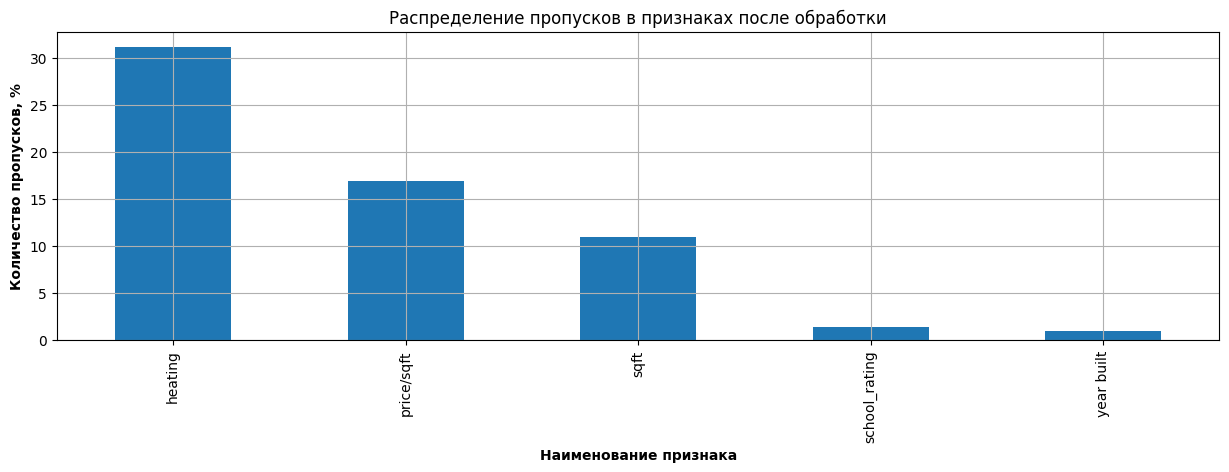

In [256]:
#визуализируем пропущенные значения в признаках после обработки
cols_with_null.plot(
    kind='bar',
    figsize=(15, 4),
    title='Распределение пропусков в признаках после обработки',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Количество пропусков, %", fontweight="bold");

У нас три признака в которых остались пропуски, один пропуск больше 30%.

Удаление дубликатов

In [257]:
#проверим есть ли у нас дубликаты в данных
data2.duplicated().sum()

3921

In [258]:
#удалим дубликаты
data2.drop_duplicates(inplace=True)
#сбросим индексы
data2.reset_index(drop=True, inplace=True)
data2.shape

(370237, 16)

Заполненим пропущенные значения

Вывод: Пропуски в schools_rating заполним медианным значением по city

In [259]:
#заменим пропуски в schools_rating
data2['school_rating'] = data2['school_rating'].fillna(data2.groupby('city')['school_rating'].transform('median').round(1))

 Удаление неинформативных и избыточных признаков

In [260]:
#удаляем признак с пропусками более 20% 
data2.drop(['heating'], axis=1, inplace=True)

In [261]:
# условия фильтрации
mask1 = data2.target.isnull() # пустые значения в признаке target
mask2 = ~data2['sqft'].isnull() # непустые значения в признаке sqft
mask3 = ~data2['price/sqft'].isnull() # непустые значения в признаке sqft
# строки, в которых можно заполнить пропуски в целевом признаке
data2[mask1 & mask2 & mask3][['target', 'sqft', 'price/sqft']]

Empty DataFrame
Columns: [target, sqft, price/sqft]
Index: []

In [262]:
# результат произведения помещаем в target
data2.loc[data2[mask1 & mask2 & mask3].index, ['target']] = data2['price/sqft'] * data2['sqft']

In [263]:
#условия фильтрации
mask4 = data2.sqft.isnull()
mask5 = (~data2['target'].isnull()) & (data2['target'] != 0)
mask6 = (~data2['price/sqft'].isnull()) & (data2['price/sqft'] != 0)
# строки, в которых можно заполнить пропуски в целевом признаке
data2[mask4 & mask5 & mask6][['target', 'sqft', 'price/sqft']]

target  sqft  price/sqft
7        68000   NaN        57.0
365      54995   NaN        46.0
449     129900   NaN        81.0
1158     28500   NaN        24.0
1233    375000   NaN       191.0
...        ...   ...         ...
369115    1650   NaN         2.0
369587  545000   NaN       222.0
369771   59900   NaN        50.0
369948  199900   NaN       125.0
370016  109000   NaN        45.0

[1258 rows x 3 columns]

In [264]:
# результат помещаем в sqft
data2.loc[data2[mask4 & mask5 & mask6].index, ['sqft']] = data2['target']/data2['price/sqft']

In [265]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370237 entries, 0 to 370236
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         370237 non-null  object 
 1   propertyType   370237 non-null  object 
 2   street         370237 non-null  object 
 3   baths          370237 non-null  float64
 4   city           370237 non-null  object 
 5   sqft           330676 non-null  float64
 6   zipcode        370237 non-null  object 
 7   state          370237 non-null  object 
 8   target         370237 non-null  int32  
 9   pool           370237 non-null  int64  
 10  year built     366674 non-null  object 
 11  cooling        370237 non-null  int64  
 12  parking        370237 non-null  int64  
 13  price/sqft     307076 non-null  float64
 14  school_rating  370172 non-null  float64
dtypes: float64(4), int32(1), int64(3), object(7)
memory usage: 41.0+ MB


`Разведывательный анализ`

In [266]:
#посмотрим статистику по числовым признакам
data2.describe()

baths          sqft        target           pool  \
count  370237.000000  3.306760e+05  3.702370e+05  370237.000000   
mean        2.406089  6.680843e+03  6.425008e+05       0.116925   
std        19.004992  1.595997e+06  1.814467e+06       0.321331   
min         0.000000  0.000000e+00  1.000000e+00       0.000000   
25%         0.000000  1.238000e+03  1.865000e+05       0.000000   
50%         2.000000  1.797000e+03  3.200000e+05       0.000000   
75%         3.000000  2.581000e+03  5.800000e+05       0.000000   
max       750.000000  7.959794e+08  1.950000e+08       1.000000   

             cooling        parking    price/sqft  school_rating  
count  370237.000000  370237.000000  3.070760e+05  370172.000000  
mean        0.669949       0.527027  4.810141e+02       5.160384  
std         0.470232       0.499270  2.306869e+04       1.932663  
min         0.000000       0.000000  0.000000e+00       1.000000  
25%         0.000000       0.000000  1.220000e+02       3.700000  
50%         1.000000       1.000000  1.770000e+02       5.000000  
75%         1.000000       1.000000  3.000000e+02       6.500000  
max         1.000000       1.000000  5.950000e+06      10.000000

Вывод: Мы видим что у нас есть выбросы: Например в признаке baths максимальное значение 750, что явно не может быть правдой.
В признаке sqft максимальное значение 795 млн. В признаке target максимальное значение 195 млн.
Для того что б убедиться, что мы правильно интерпритировали данные, построим визуализируем с помощью гистограмм и коробчатых диаграммы распределения каждого числового признака.

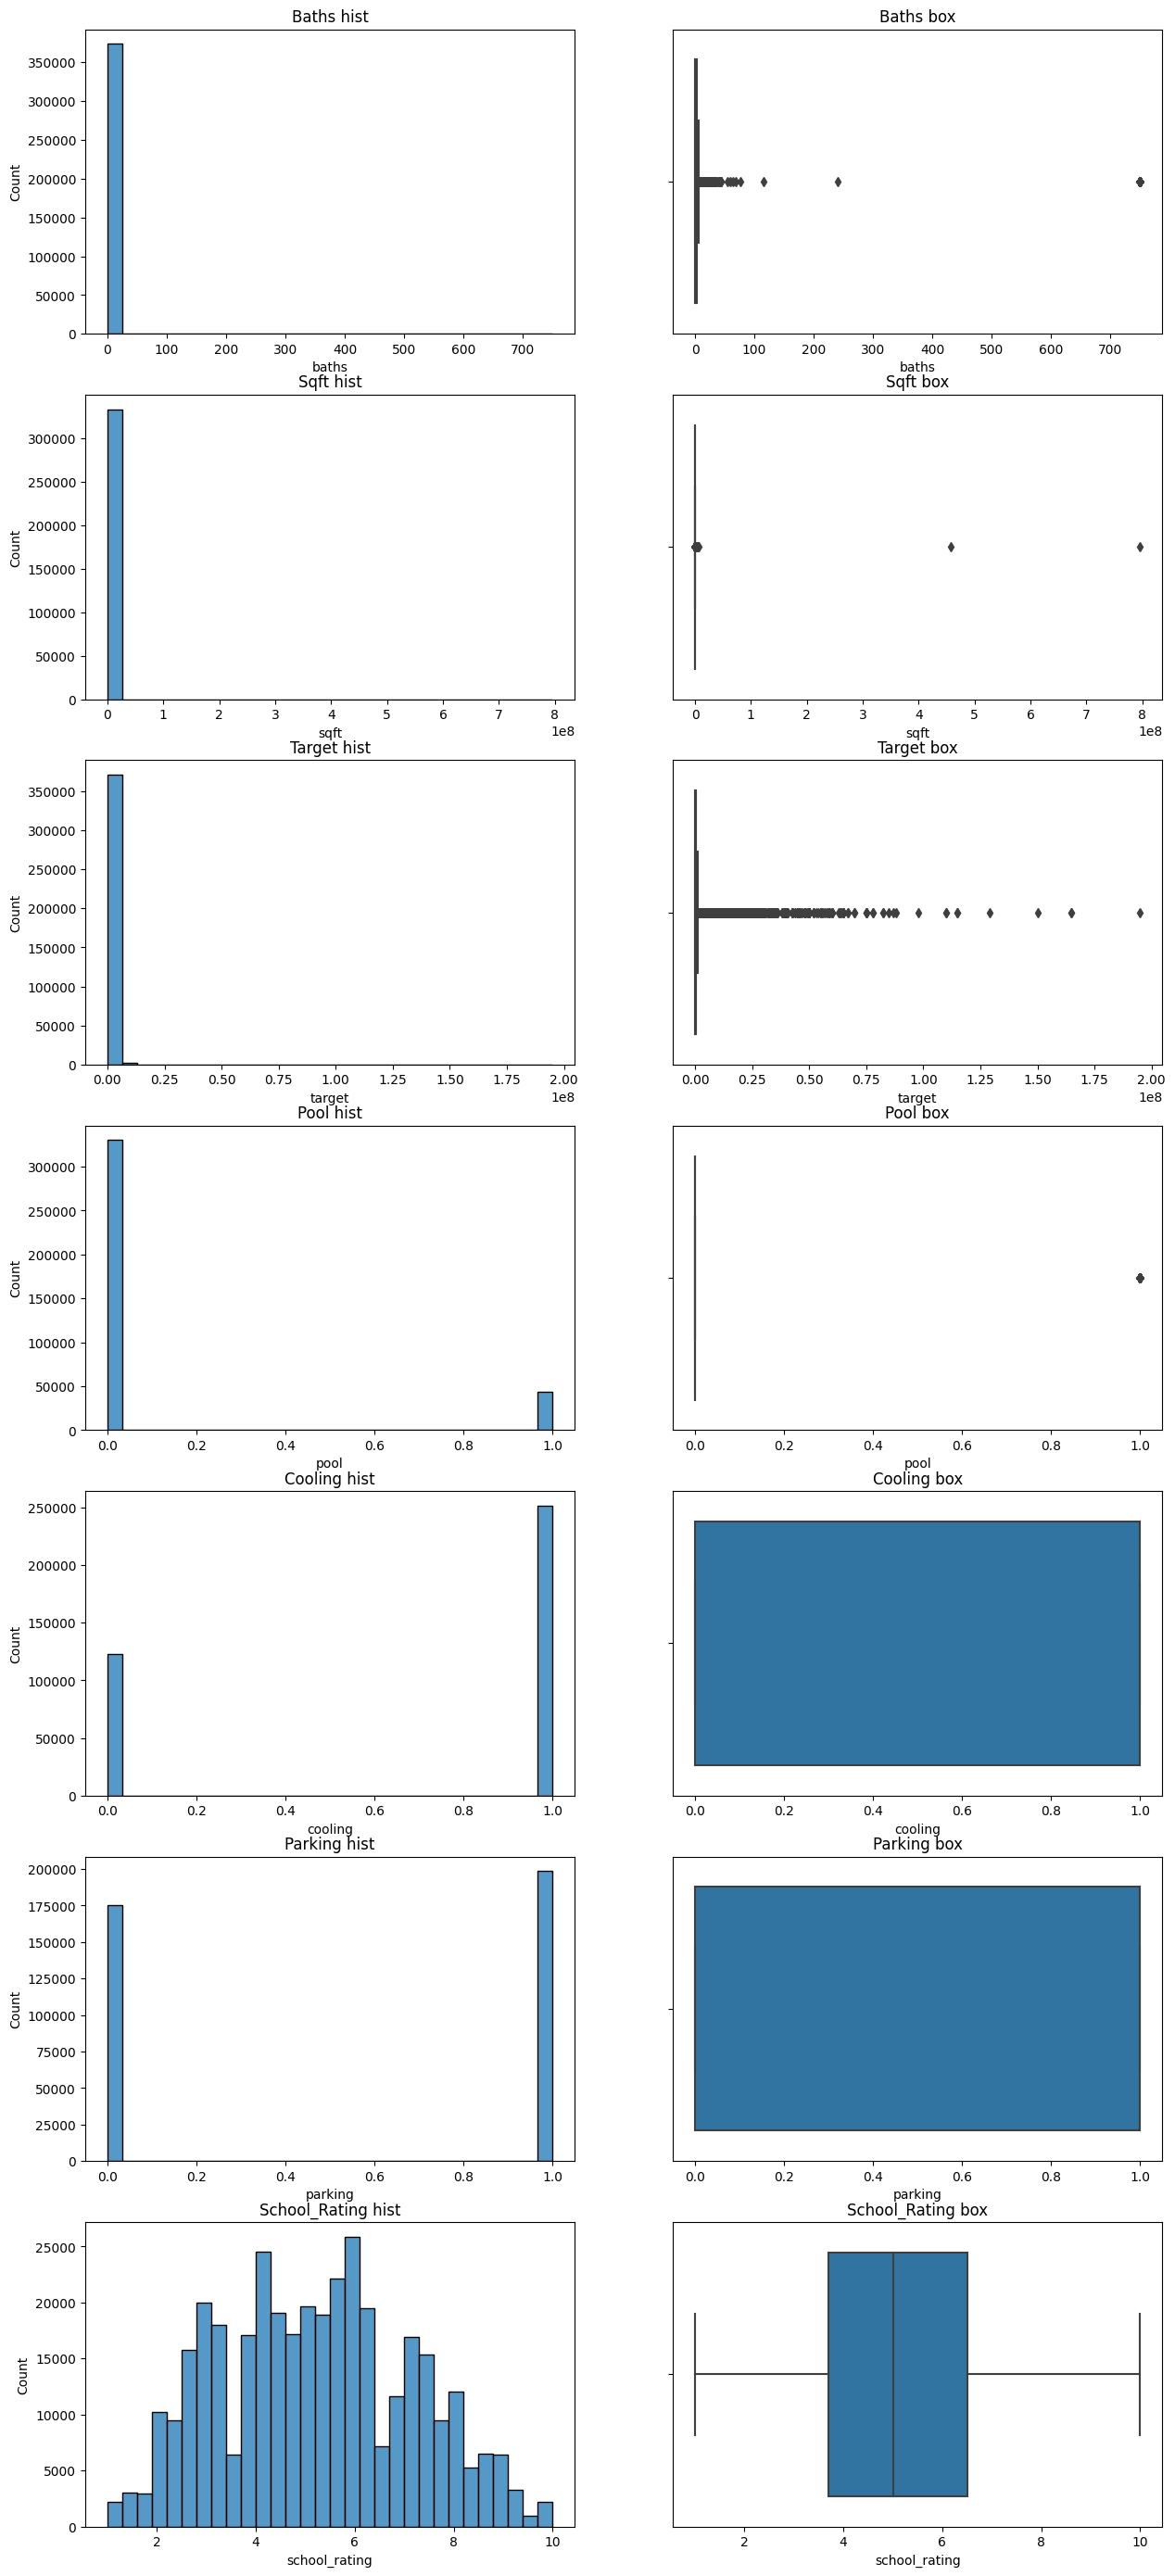

In [267]:
#создаем список с числовыми признаками 
num_features = [
'baths',
'sqft',
'target',
'pool',
'cooling',
'parking',
'school_rating'
]
#построим диаграммы
n = len(num_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 35))
for i, feature in enumerate(num_features):
    num_histplot = sns.histplot(data=data1, x=feature, bins=30, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist")
    num_boxplot = sns.boxplot(data=data1, x=feature, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box")

Вывод. Построенные графики подтверждают наличие выбросов в признаках, мы не ошиблись. 

Изучение выбросов в признаке target

In [268]:
#выведим самые дорогие объекты в признаке, которые больше $100 млн
data2[data2['target'] > 1e8]

status        propertyType               street  baths           city  \
53679   active  single family home  2571 Wallingford Dr   24.0  Beverly Hills   
108894  active  single family home         Tortuoso Way    0.0    Los Angeles   
118516  active  single family home   141 S Carolwood Dr   10.0    Los Angeles   
130898  active  single family home         875 Nimes Rd   18.0    Los Angeles   
141857  active  single family home   67 Beverly Park Ct   23.0  Beverly Hills   
176663  active  single family home        9505 Lania Ln   23.0  Beverly Hills   
289551  active  single family home   141 S Carolwood Dr   10.0    Los Angeles   
347999  active                land       1441 Angelo Dr    0.0  Beverly Hills   

           sqft zipcode state     target  pool year built  cooling  parking  \
53679   38000.0   90210    CA  110000000     1       2000        1        1   
108894      NaN   90077    CA  150000000     1    no date        0        0   
118516  12201.0   90077    CA  115000000     1       1936        1        1   
130898      NaN   90077    CA  195000000     1       1935        1        1   
141857  28660.0   90210    CA  165000000     1       1998        1        1   
176663  43000.0   90210    CA  129000000     1       2002        1        1   
289551  12201.0   90077    CA  115000000     1       1936        1        0   
347999    741.0   90210    CA  110000000     0       2007        1        0   

        price/sqft  school_rating  
53679       2895.0            7.3  
108894         NaN            7.3  
118516      9425.0            7.3  
130898         NaN            8.5  
141857      5757.0            7.3  
176663      3000.0            7.3  
289551      9425.0            7.3  
347999    148448.0            7.3

Вывод: Мы видим что самые дорогие дома находяться в Лос-Анжелесе и Беверли-Хилс. Вспоминаем, где находяться эти города? Голливуд, а это самый дорогой и фешенебельный штат Калифорния. У домов большая площадь, много ванных комнат,бассейны, камины и школы с очень высоким рейтингом. В штате проживают звезды, рядом кремниевая долина, что только повышает цены на недвижимость.
Для лучшего восприятия построим диаграмму, стоимости жилья по штатам.

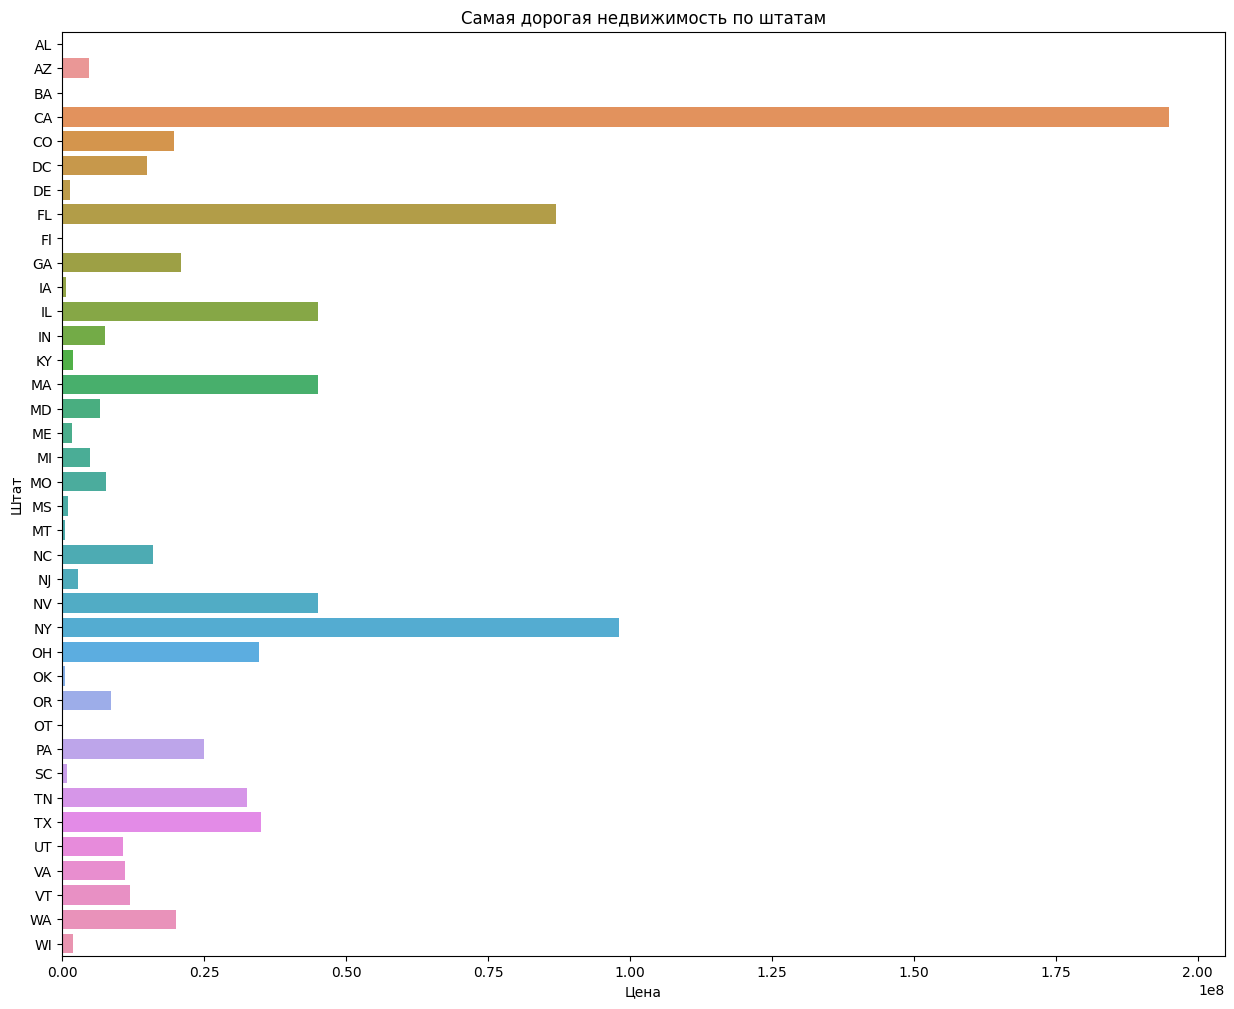

In [269]:
#визуализацию стоимости недвижимости по штатам самой дорогой
price_per_state = data2.groupby(by='state', as_index=False)['target'].max()
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(price_per_state, x='target', y='state', ax=ax)
ax.set_title('Самая дорогая недвижимость по штатам')
ax.set_ylabel('Штат')
ax.set_xlabel('Цена');

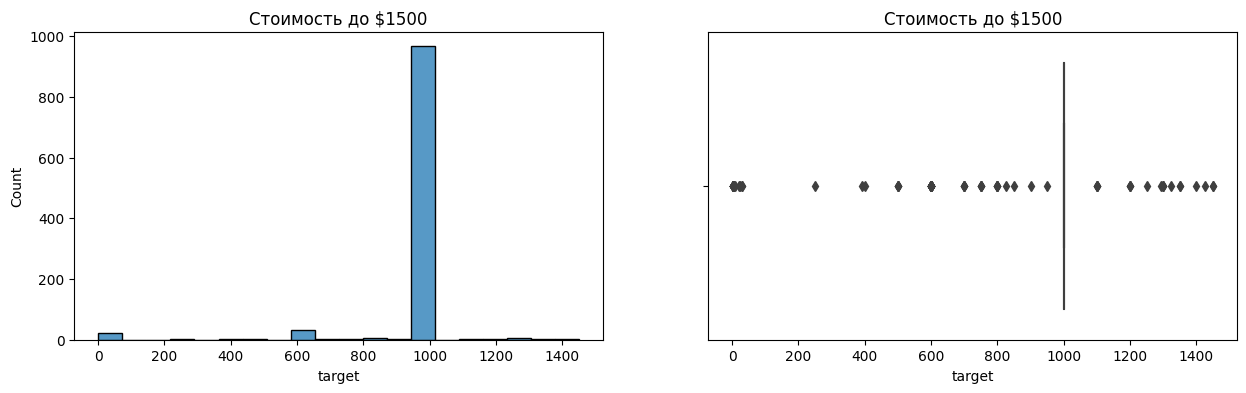

In [270]:
#гистограмму и коробчатую диаграмму с ценой до $1500
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data2[data2.target < 1500], x='target', bins=20, ax=axes[0])
histplot.set_title('Стоимость до $1500')
boxplot = sns.boxplot(data=data2[data2.target < 1500], x='target', ax=axes[1])
boxplot.set_title('Стоимость до $1500');

Вывод: На диаграмме мы видим очевидный выброс в районе 0, остальные цены начинаются с $200. Может быть это обьект который не продаеться, или ошибка ввода данных.


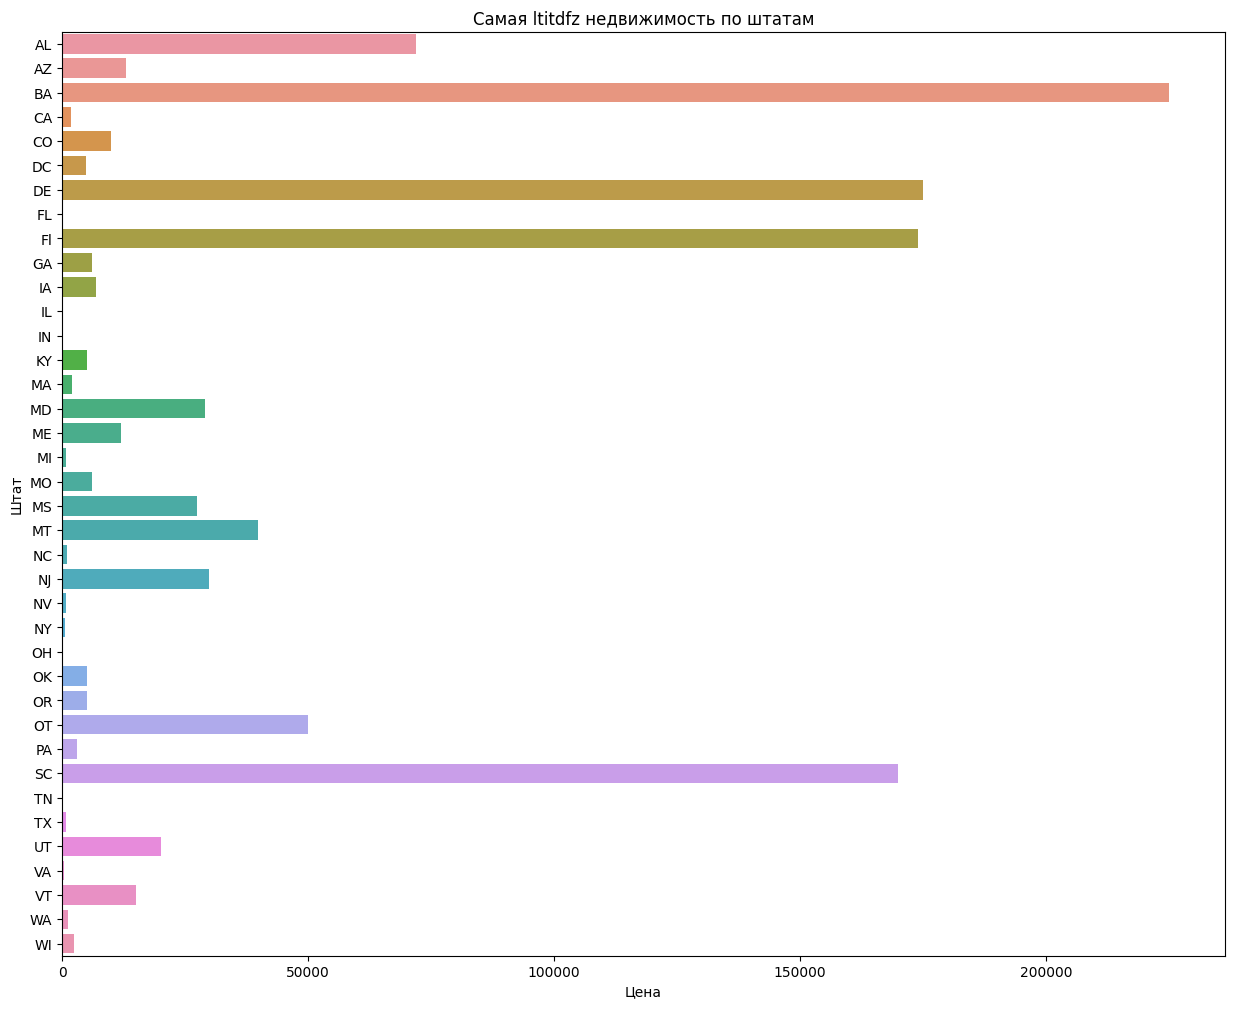

In [271]:
price_per_state = data2.groupby(by='state', as_index=False)['target'].min()
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(price_per_state, x='target', y='state', ax=ax)
ax.set_title('Самая ltitdfz недвижимость по штатам')
ax.set_ylabel('Штат')
ax.set_xlabel('Цена');

In [272]:
#посмотрим записи с ценой до $1000
data2[data2['target'] < 1000].tail(10)

status           propertyType                    street  baths  \
315317      active                   land                474 2nd St    0.0   
315450      active                   land                Lookout Rd    0.0   
316137  foreclosed                  condo          9115 Sea Oats Dr    3.0   
328431      active                   land                High St NW    0.0   
344919  foreclosed                   land        217 Livingston Ave    0.0   
347051       other                  condo  18707 NE 2nd Ave APT 906    0.0   
348498  foreclosed                   land                5 Park Ave    0.0   
350598  foreclosed                   land                1 Bohl Ave    0.0   
358467  foreclosed  singlefamilyresidence              66 Albany St    0.0   
361755       other                    nan        900 Bay Dr # DS1/2    0.0   

                city    sqft zipcode state  target  pool year built  cooling  \
315317        Albany     NaN   12206    NY     600     0       1900        0   
315450        Amanda     0.0   43102    OH       1     0    no date        0   
316137  Indianapolis  1780.0   46250    IN       1     0       1989        1   
328431      Abingdon     0.0   24210    VA     400     0    no date        0   
344919        Albany  1083.0   12210    NY     500     0       1870        0   
347051         Miami   425.0   33179    FL     850     0       None        1   
348498        Albany     NaN   12202    NY     600     0    no date        0   
350598        Albany     NaN   12209    NY     600     0    no date        0   
358467        Albany     NaN   12204    NY     600     0    no date        0   
361755   Miami Beach     NaN   33141    FL     700     0       None        0   

        parking  price/sqft  school_rating  
315317        0         NaN            2.7  
315450        0         NaN            6.6  
316137        1         0.0            3.7  
328431        0         NaN            5.5  
344919        0         0.0            3.0  
347051        1         2.0            7.0  
348498        0         NaN            2.3  
350598        0         NaN            4.0  
358467        0         NaN            2.3  
361755        0         NaN            7.5

`Статистический тест на нормальность распределения данных`

Проверим гипотезу о нормальности распределения данных в признаке target с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

In [273]:
# проверка гипотезы о нормальности распределения
H0 = 'Данные в признаке target распределены нормально'
Ha = 'Данные в признаке target не распределены нормально.Отвергаем нулевую гипотезу'
alpha = 0.05

_, p = stats.normaltest(data2[['target']])
print(p[0])

if p[0] > alpha/2:
    print(H0)
else:
    print(Ha)

0.0
Данные в признаке target не распределены нормально.Отвергаем нулевую гипотезу


Вывод: Данные не распределены нормально и поэтому для очистки от выбросов будем использовать метод z-отклонений с логарифмированием признаков.

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3 $\sigma$)

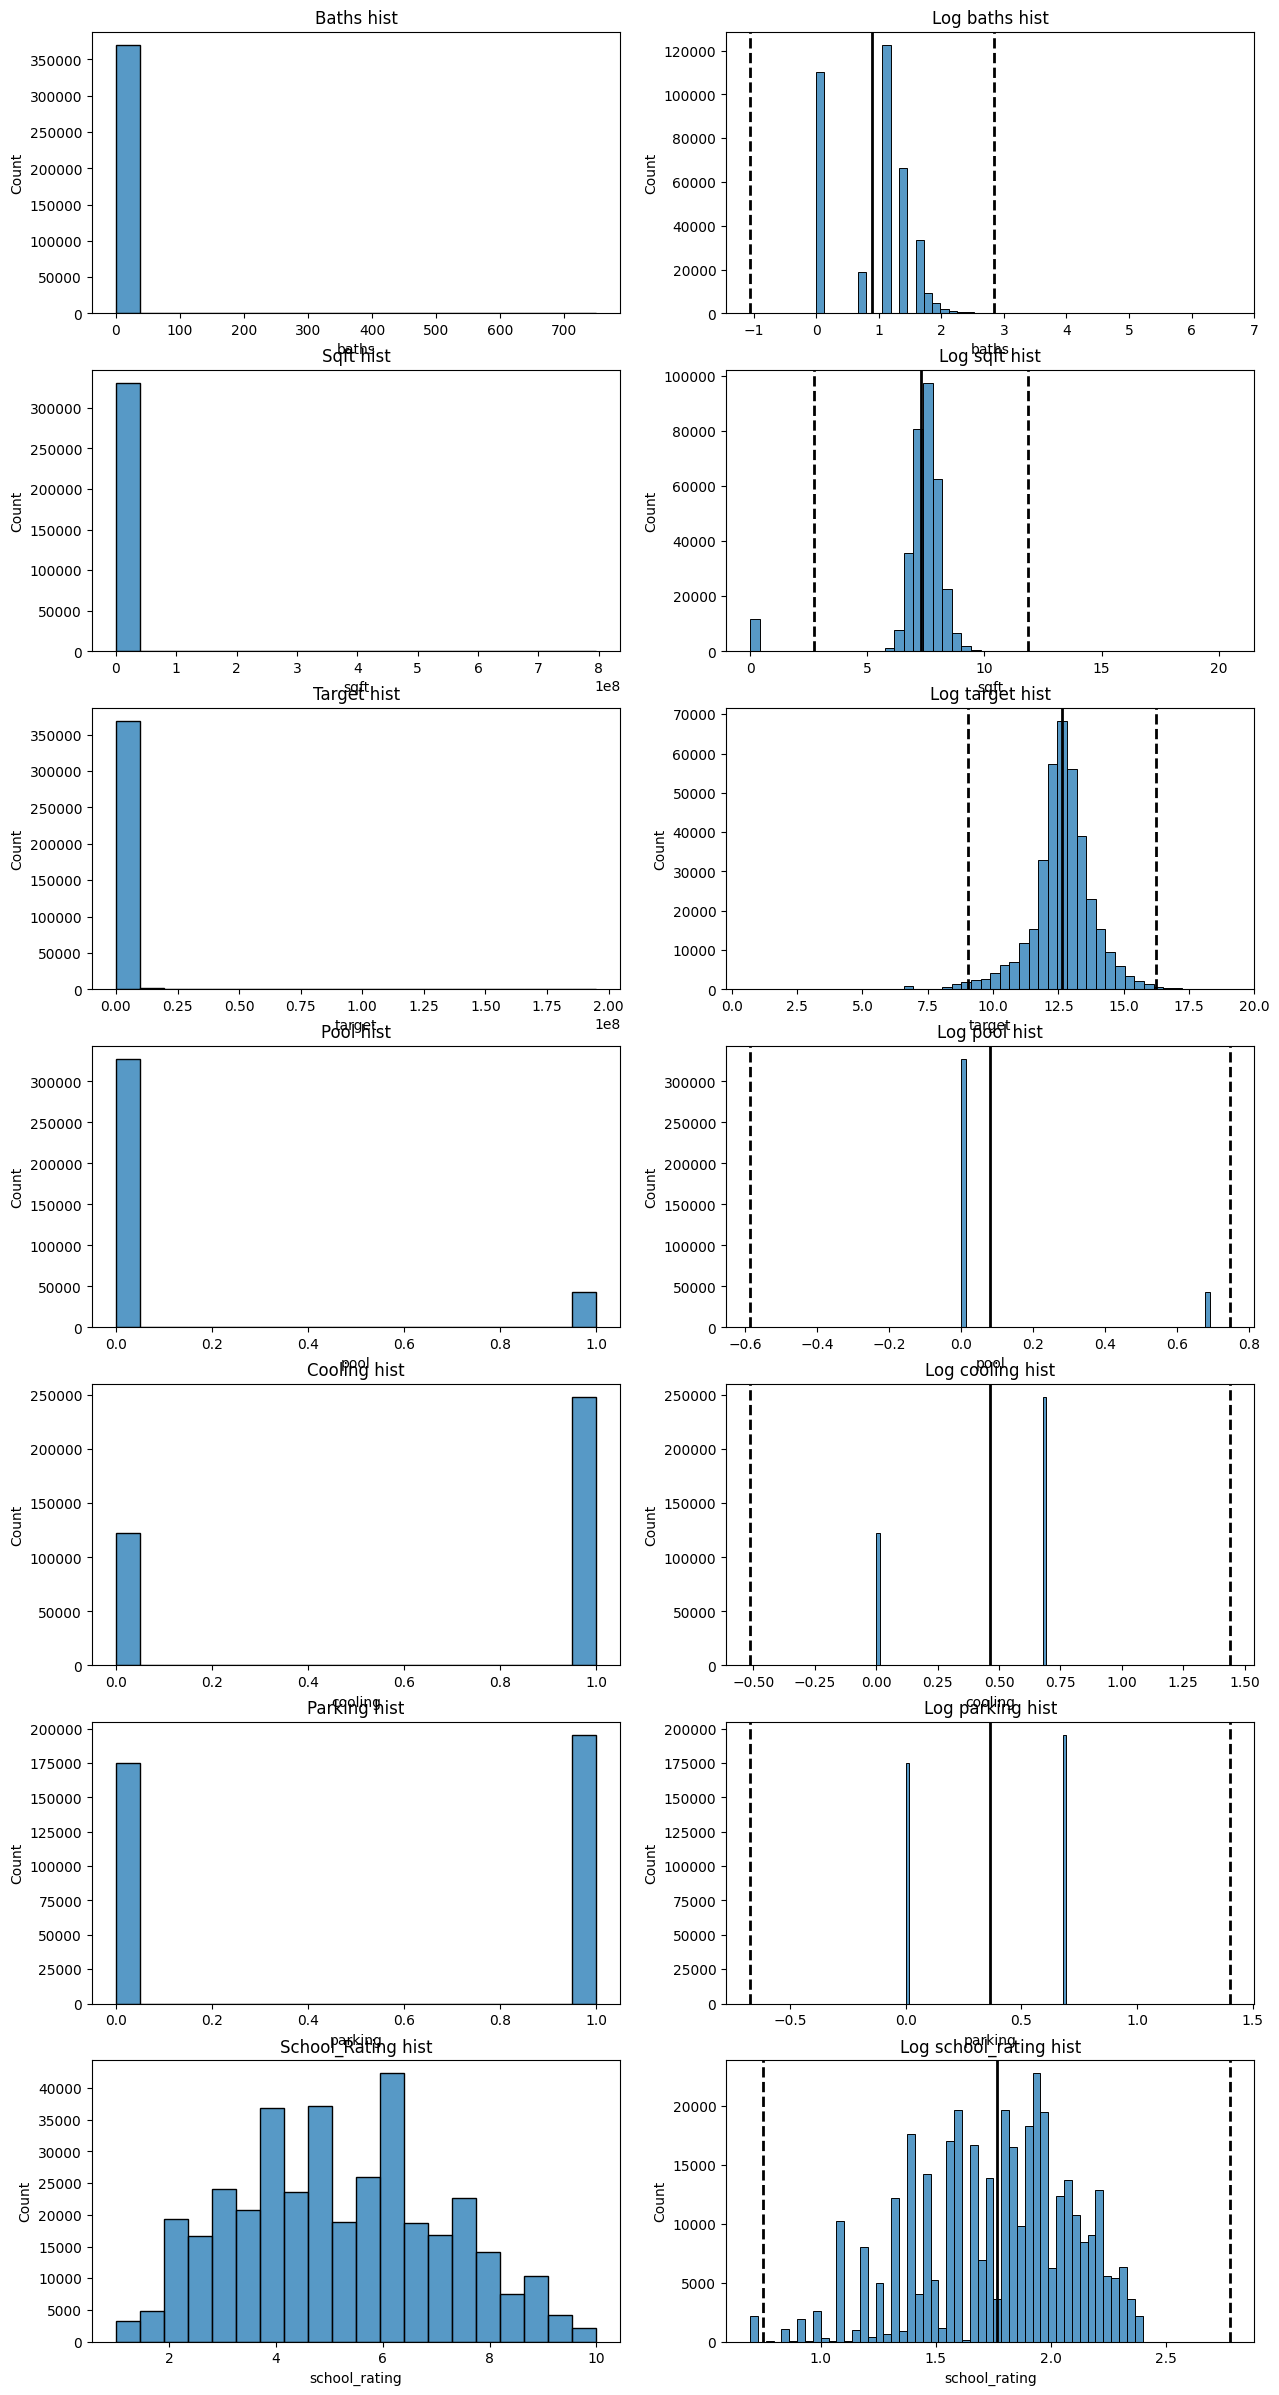

In [274]:
#построим гистограммы распределения числовых признаков в обычном и логарифмированном виде
fig, axes = plt.subplots(n, 2, figsize=(15, 30))
for i, feature in enumerate(num_features):
    #строим гистограмму
    num_histplot = sns.histplot(data=data2, x=feature, bins=20, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist")
    #логарифмируем
    log_feature = np.log(data2[feature]+1)
    #строим гистограмму в логарифмическом масштабе
    log_boxplot = sns.histplot(data=log_feature, bins=50, ax=axes[i][1])
    log_boxplot.set_title(f"Log {feature.title().lower()} hist")
    #добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
    axes[i][1].axvline(log_feature.mean(), color='k', lw=2)
    axes[i][1].axvline(log_feature.mean()+ 3 *log_feature.std(),
                color='k', ls='--', lw=2)
    axes[i][1].axvline(log_feature.mean()- 3 *log_feature.std(),
                color='k', ls='--', lw=2);

С помощью функции выполняем очистку

In [275]:
#объявляем функцию реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [276]:
#производим очистку
for feature in num_features:
    outliers, temp_cleaned = outliers_z_score(data2, feature, log_scale=True)
    print('Shape before cleaning outliers: {}'.format(data2.shape))
    print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))
    drop_data = temp_cleaned

Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (369852, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (318339, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (364180, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (370237, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (370237, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (370237, 15)
Shape before cleaning outliers: (370237, 15)
Shape after cleaning outliers: (367973, 15)


 После очистки строим визуализацию распределений числовых признаков

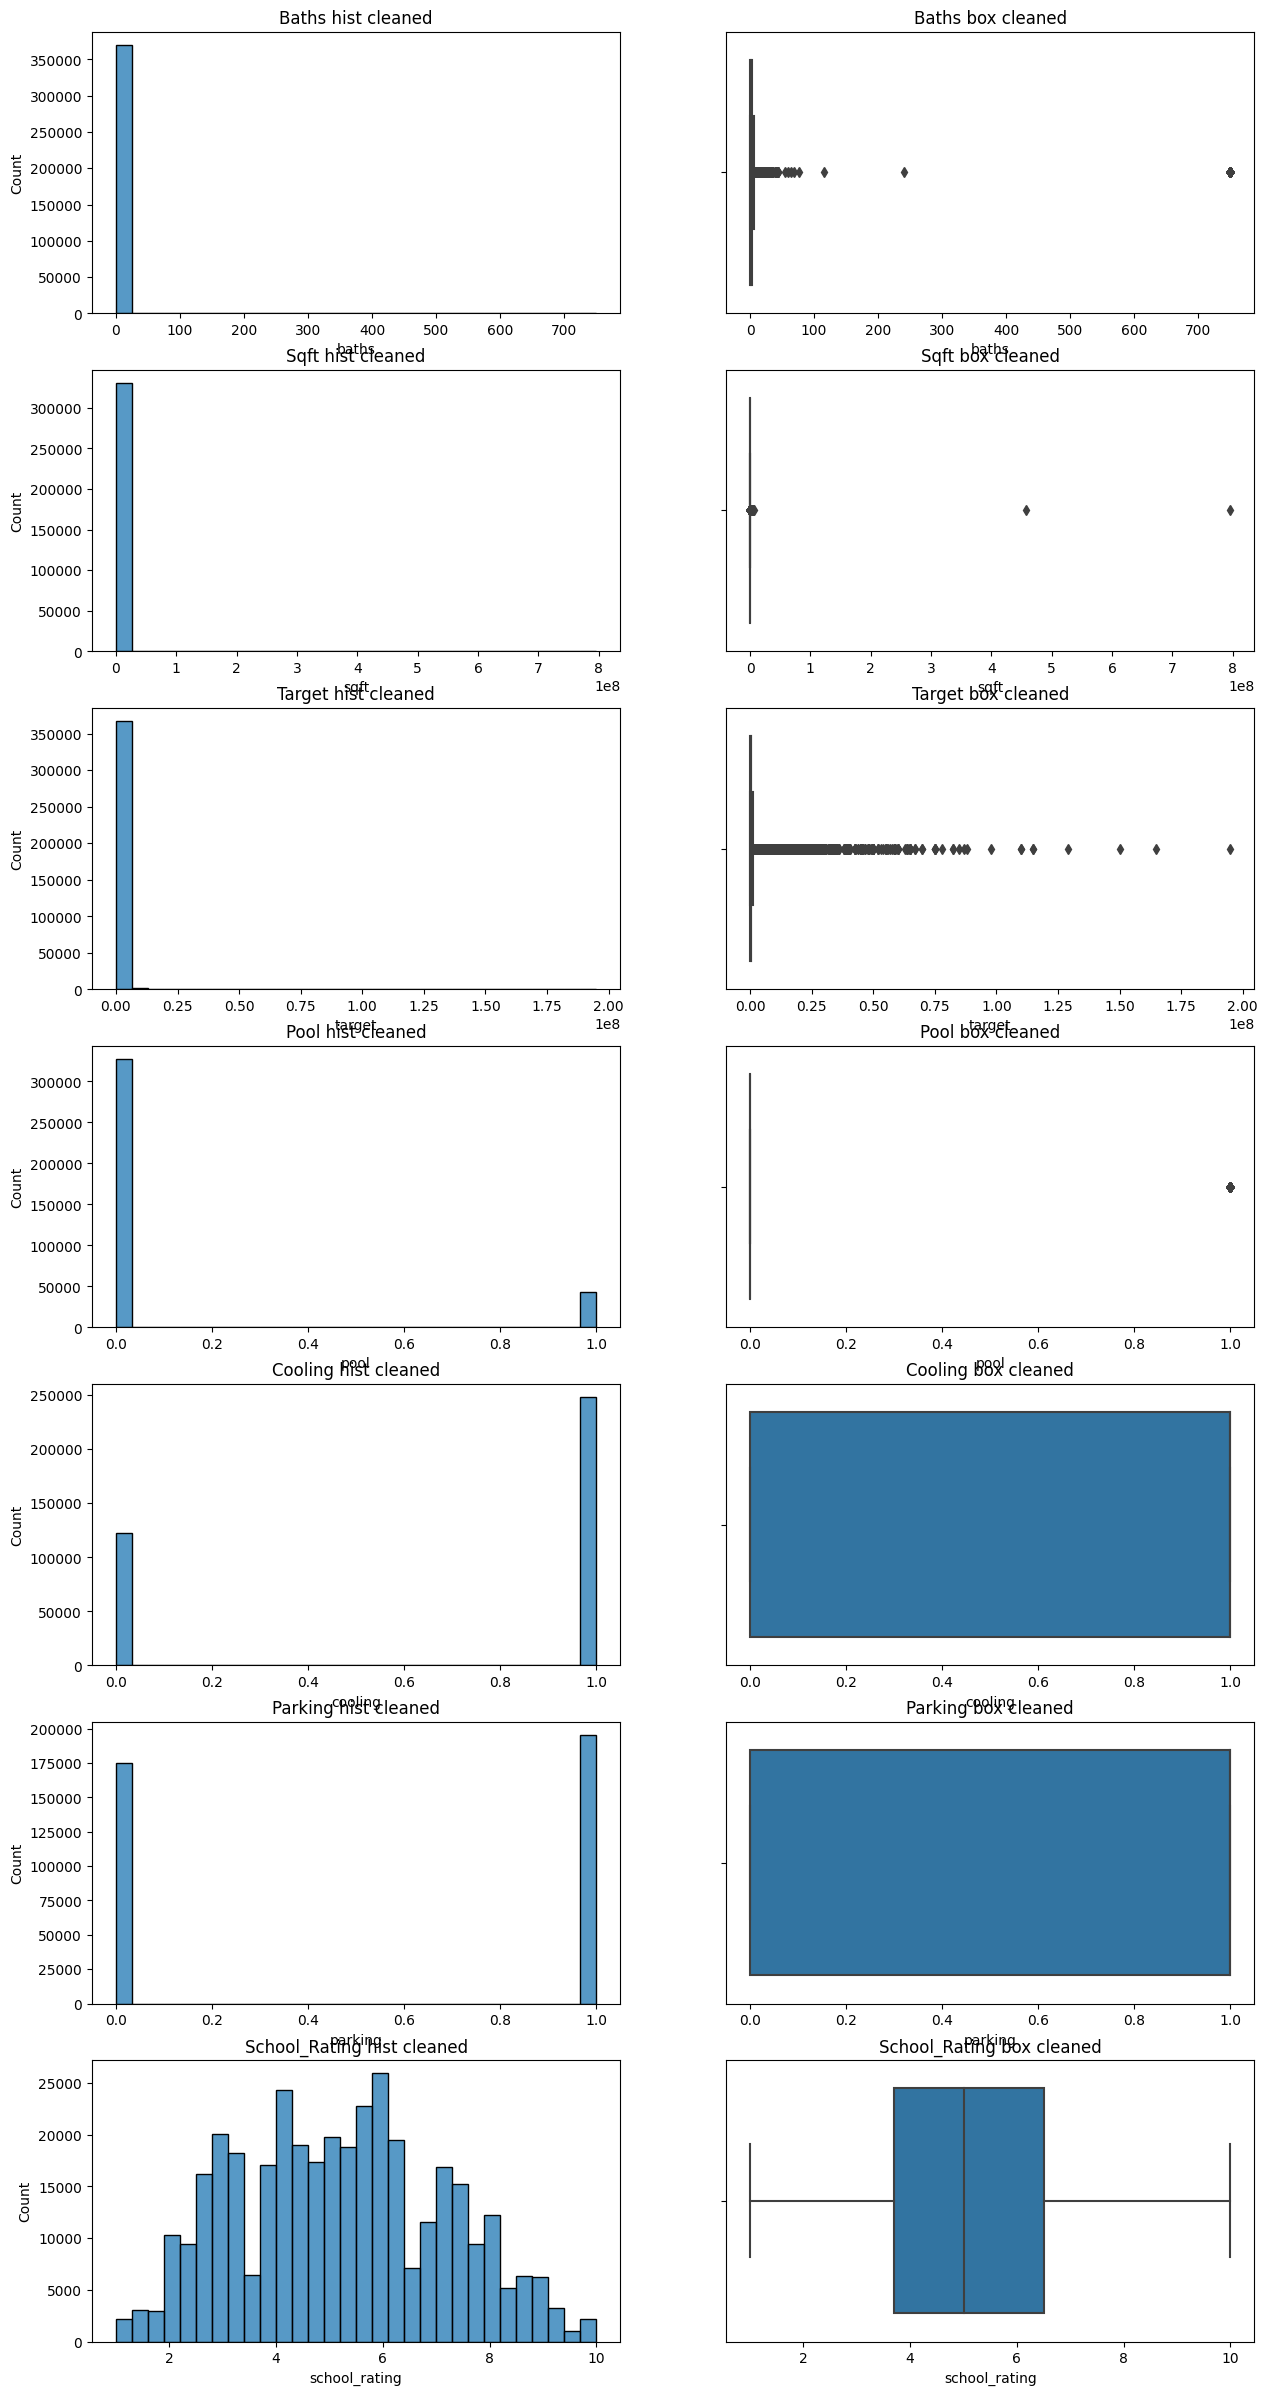

In [277]:
#визуализация распределений числовых признаков после очистки
fig, axes = plt.subplots(n, 2, figsize=(15, 30))
for i, feature in enumerate(num_features):
    num_histplot = sns.histplot(data=data2, x=feature, bins=30, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist cleaned")
    num_boxplot = sns.boxplot(data=data2, x=feature, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box cleaned")

Очистка выполнена, при этом сохранились записи, не являющиеся выбросами, такие например как высокая цена.

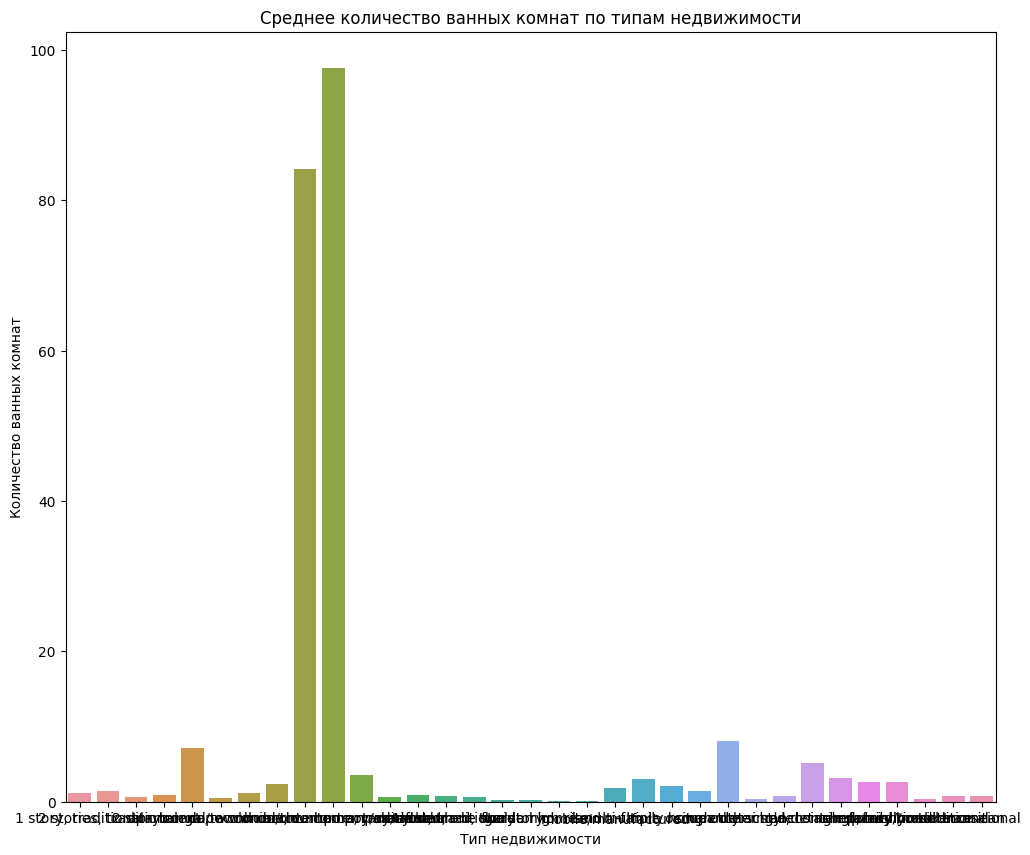

In [278]:
# построим визуализацию зависимости среднего количества ванных комнат от типа недвижимости
baths_per_type = data2.groupby(by='propertyType', as_index=False)['baths'].mean()
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(baths_per_type, x='propertyType', y='baths', ax=ax)
ax.set_title('Среднее количество ванных комнат по типам недвижимости')
ax.set_ylabel('Количество ванных комнат')
ax.set_xlabel('Тип недвижимости');


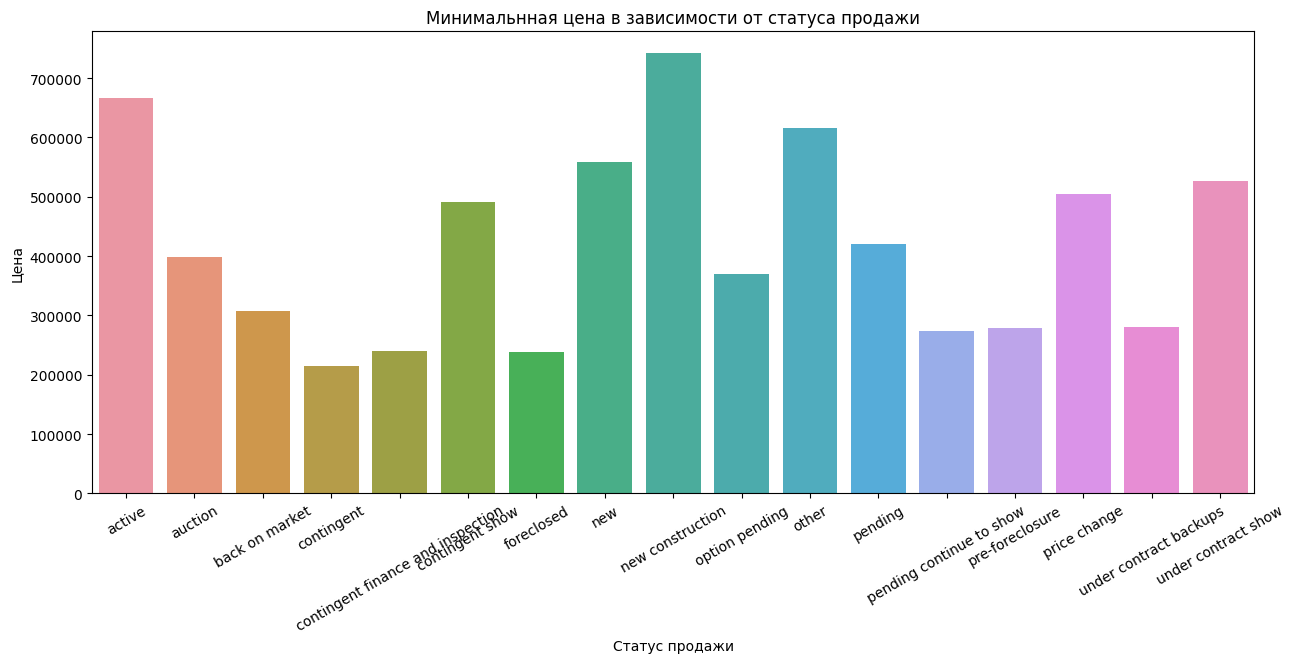

In [279]:
#построим визуализацию средней цены в зависимости от статуса продажи
price_per_status = data2.groupby(by='status', as_index=False)['target'].mean()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(price_per_status, x='status', y='target', ax=ax)
ax.set_title('Минимальнная цена в зависимости от статуса продажи')
ax.set_ylabel('Цена')
ax.set_xlabel('Статус продажи')
ax.tick_params(axis='x', rotation=30);

Построение графиков зависимости числовых признаков с целевой переменной

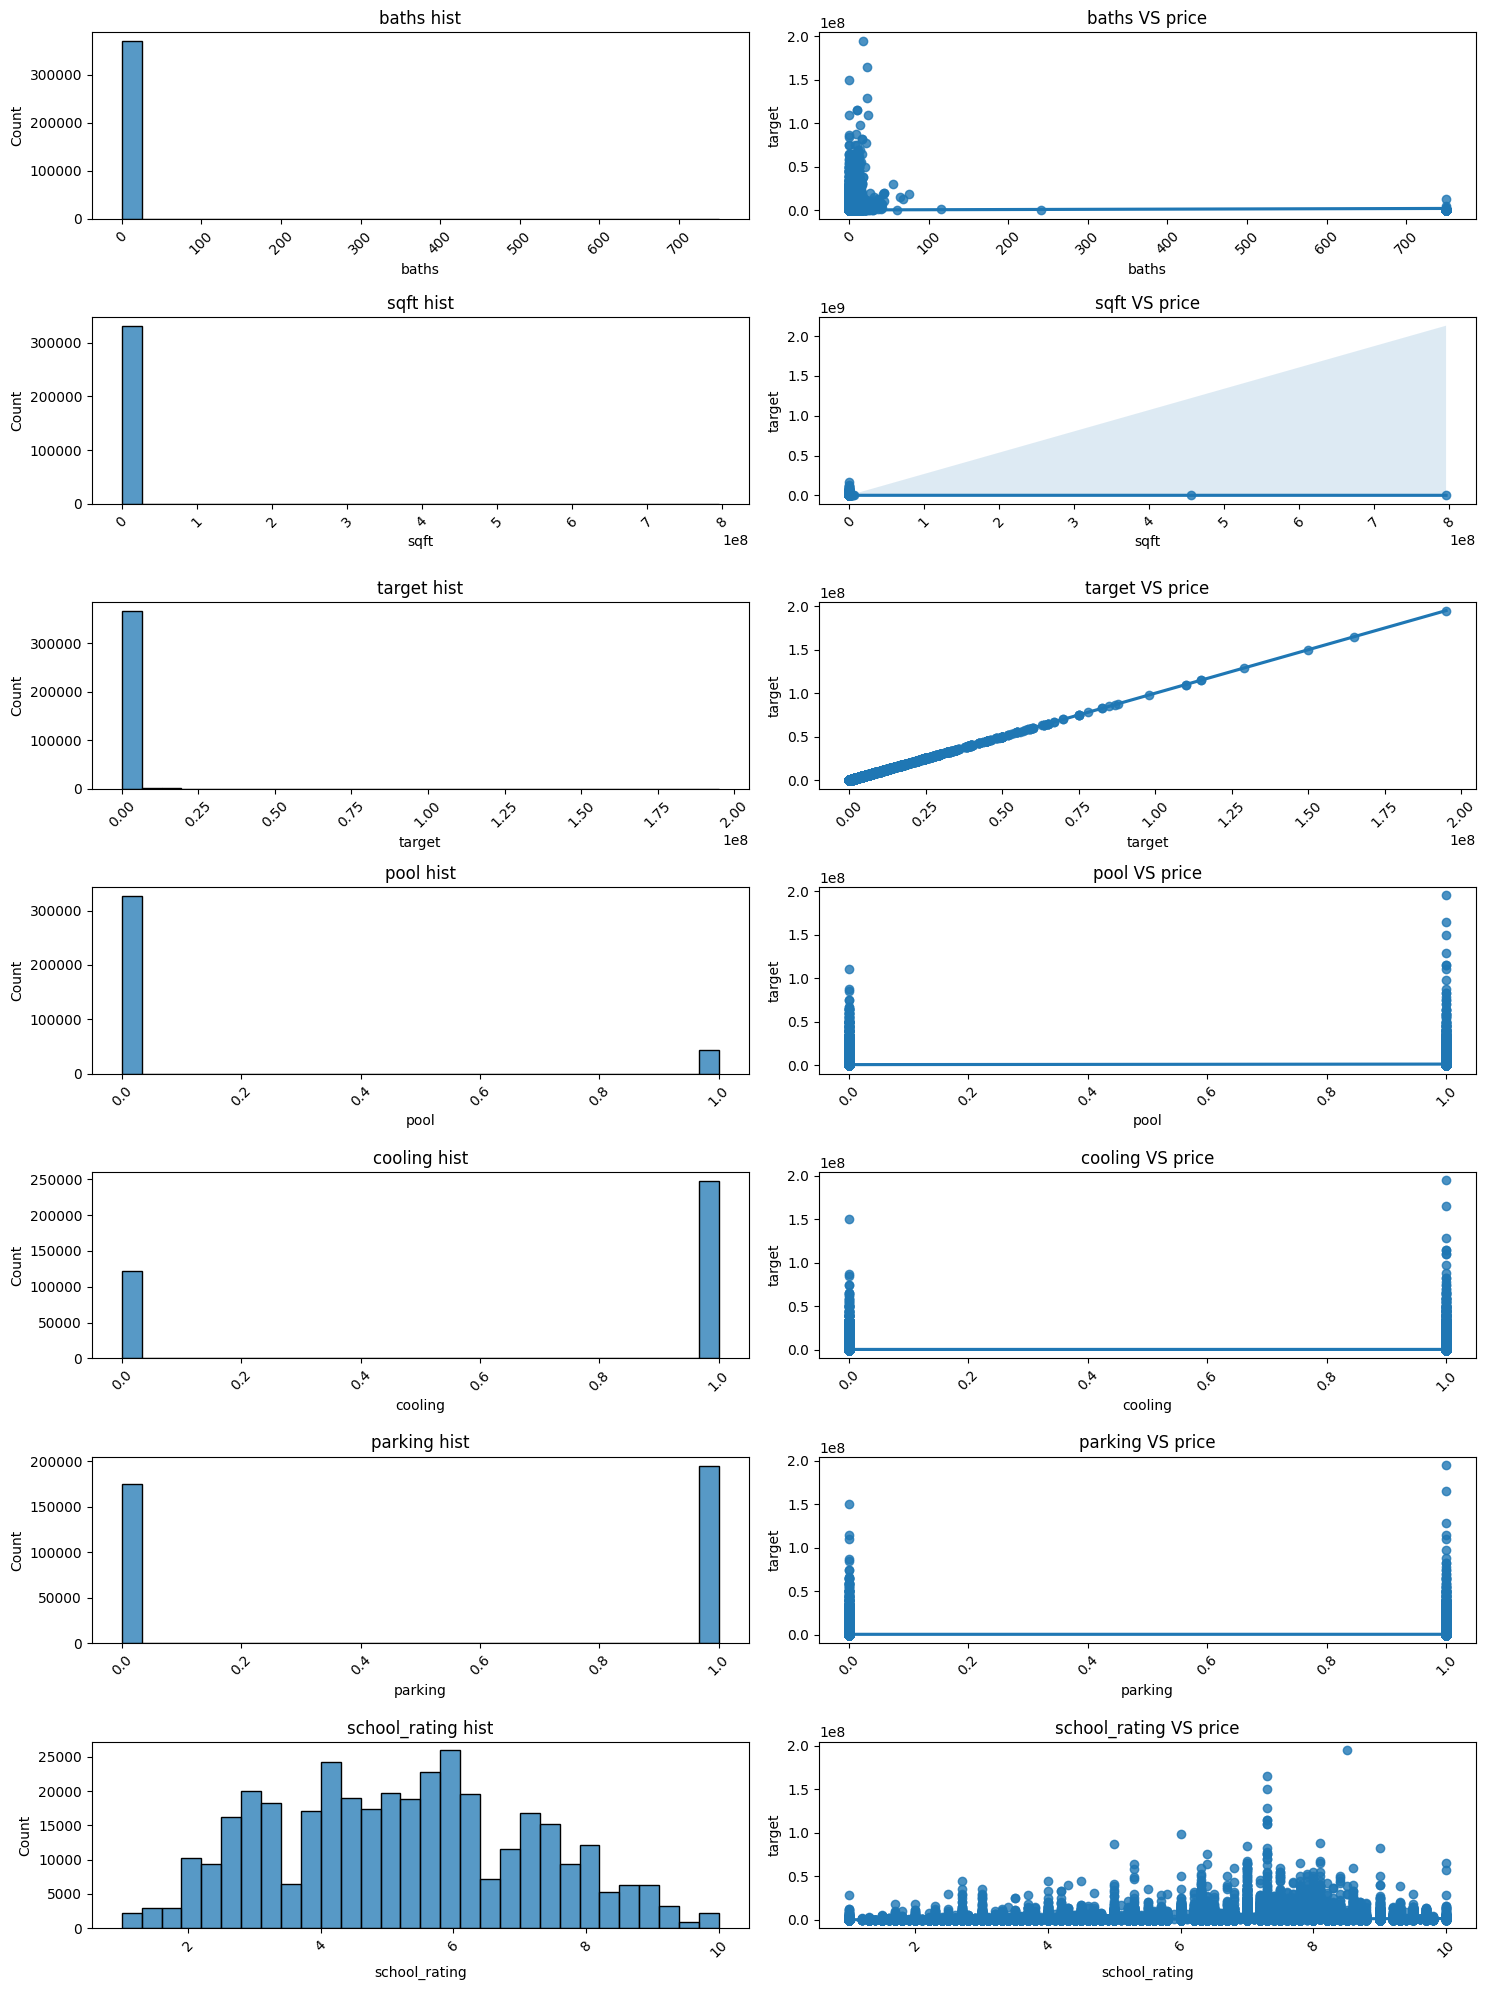

In [280]:
# числовые признаки
num_features = [
'baths',
'sqft',
'target',
'pool',
'cooling',
'parking',
'school_rating'
]
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data2, x=feature, bins=30, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data2, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Вывод: Цена недвижимости (target) напрямую зависит от площади (sqft), так же есть зависимость между ценой и рейтингом школ (school_rating).

In [281]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370237 entries, 0 to 370236
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         370237 non-null  object 
 1   propertyType   370237 non-null  object 
 2   street         370237 non-null  object 
 3   baths          370237 non-null  float64
 4   city           370237 non-null  object 
 5   sqft           330676 non-null  float64
 6   zipcode        370237 non-null  object 
 7   state          370237 non-null  object 
 8   target         370237 non-null  int32  
 9   pool           370237 non-null  int64  
 10  year built     366674 non-null  object 
 11  cooling        370237 non-null  int64  
 12  parking        370237 non-null  int64  
 13  price/sqft     307076 non-null  float64
 14  school_rating  370172 non-null  float64
dtypes: float64(4), int32(1), int64(3), object(7)
memory usage: 41.0+ MB


In [282]:
#удаляем признаки 
data2 = data2.drop(['street', 'city', 'year built', 'zipcode', 'price/sqft'], axis=1)


In [284]:
data2.dropna(axis=0, subset='sqft', inplace=True)

In [295]:
#удалим строки с пропущеными значениями в столбце street
data2= data2.dropna(subset=['school_rating'])

In [296]:
#сохраняем наш дата фрейм
data2.to_csv('clean.csv', index=False)

## Отбор признаков

In [297]:
clean = pd.read_csv('clean.csv')

In [298]:
#создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType']
#создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(clean[oh_cols])
#присоединяем к датафрейму закодированные признаки
clean = pd.concat([clean, encoded_data], axis=1)

#создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(clean[['state']])
#присоединяем к датафрейму закодированные признаки
clean = pd.concat([clean, encoded_data], axis=1)

#удаляем исходные признаки и выводим размер датафрейма
clean = clean.drop(['status', 'propertyType', 'state'], axis=1)
print('Размер получившегося датафрейма:', clean.shape)

Размер получившегося датафрейма: (330630, 63)


In [299]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330630 entries, 0 to 330629
Data columns (total 63 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   baths                                              330630 non-null  float64
 1   sqft                                               330630 non-null  float64
 2   target                                             330630 non-null  int64  
 3   pool                                               330630 non-null  int64  
 4   cooling                                            330630 non-null  int64  
 5   parking                                            330630 non-null  int64  
 6   school_rating                                      330630 non-null  float64
 7   status_active                                      330630 non-null  int64  
 8   status_other                                       330630 non-null  int64 

In [300]:
clean['school_rating'].unique()

array([ 5.2,  4. ,  6.7,  9.2,  2. ,  2.3,  2.7,  3.8,  3. ,  4.2,  7.3,
        5.3,  3.5,  2.5,  7. ,  5. ,  6.3,  6.2,  8.3,  6.5,  6. ,  8. ,
        3.7,  7.5,  9.3,  1.5,  7.7,  5.6,  3.3,  4.7,  9. ,  3.6,  5.5,
        4.3,  8.5,  8.7,  5.4,  4.6,  8.2,  4.5,  9.5,  2.9,  1.2,  4.8,
        3.2,  5.7,  1.7,  6.8,  2.2,  1.3,  5.8,  7.2, 10. ,  4.4,  2.6,
        7.8,  6.6,  2.8,  1. ,  8.8,  2.4,  6.4,  8.6,  3.4,  9.7,  8.1,
        7.4,  7.6,  2.1,  1.8,  7.9,  4.9,  3.1,  8.4,  5.1,  5.9,  9.8,
        6.9,  1.6,  9.4,  4.1,  9.6,  1.9,  1.4,  3.9,  6.1])

Проверим, нет ли сильной связи между признаками нашего датафрейма по методу Пирсона, особенно после генерации дополнительных

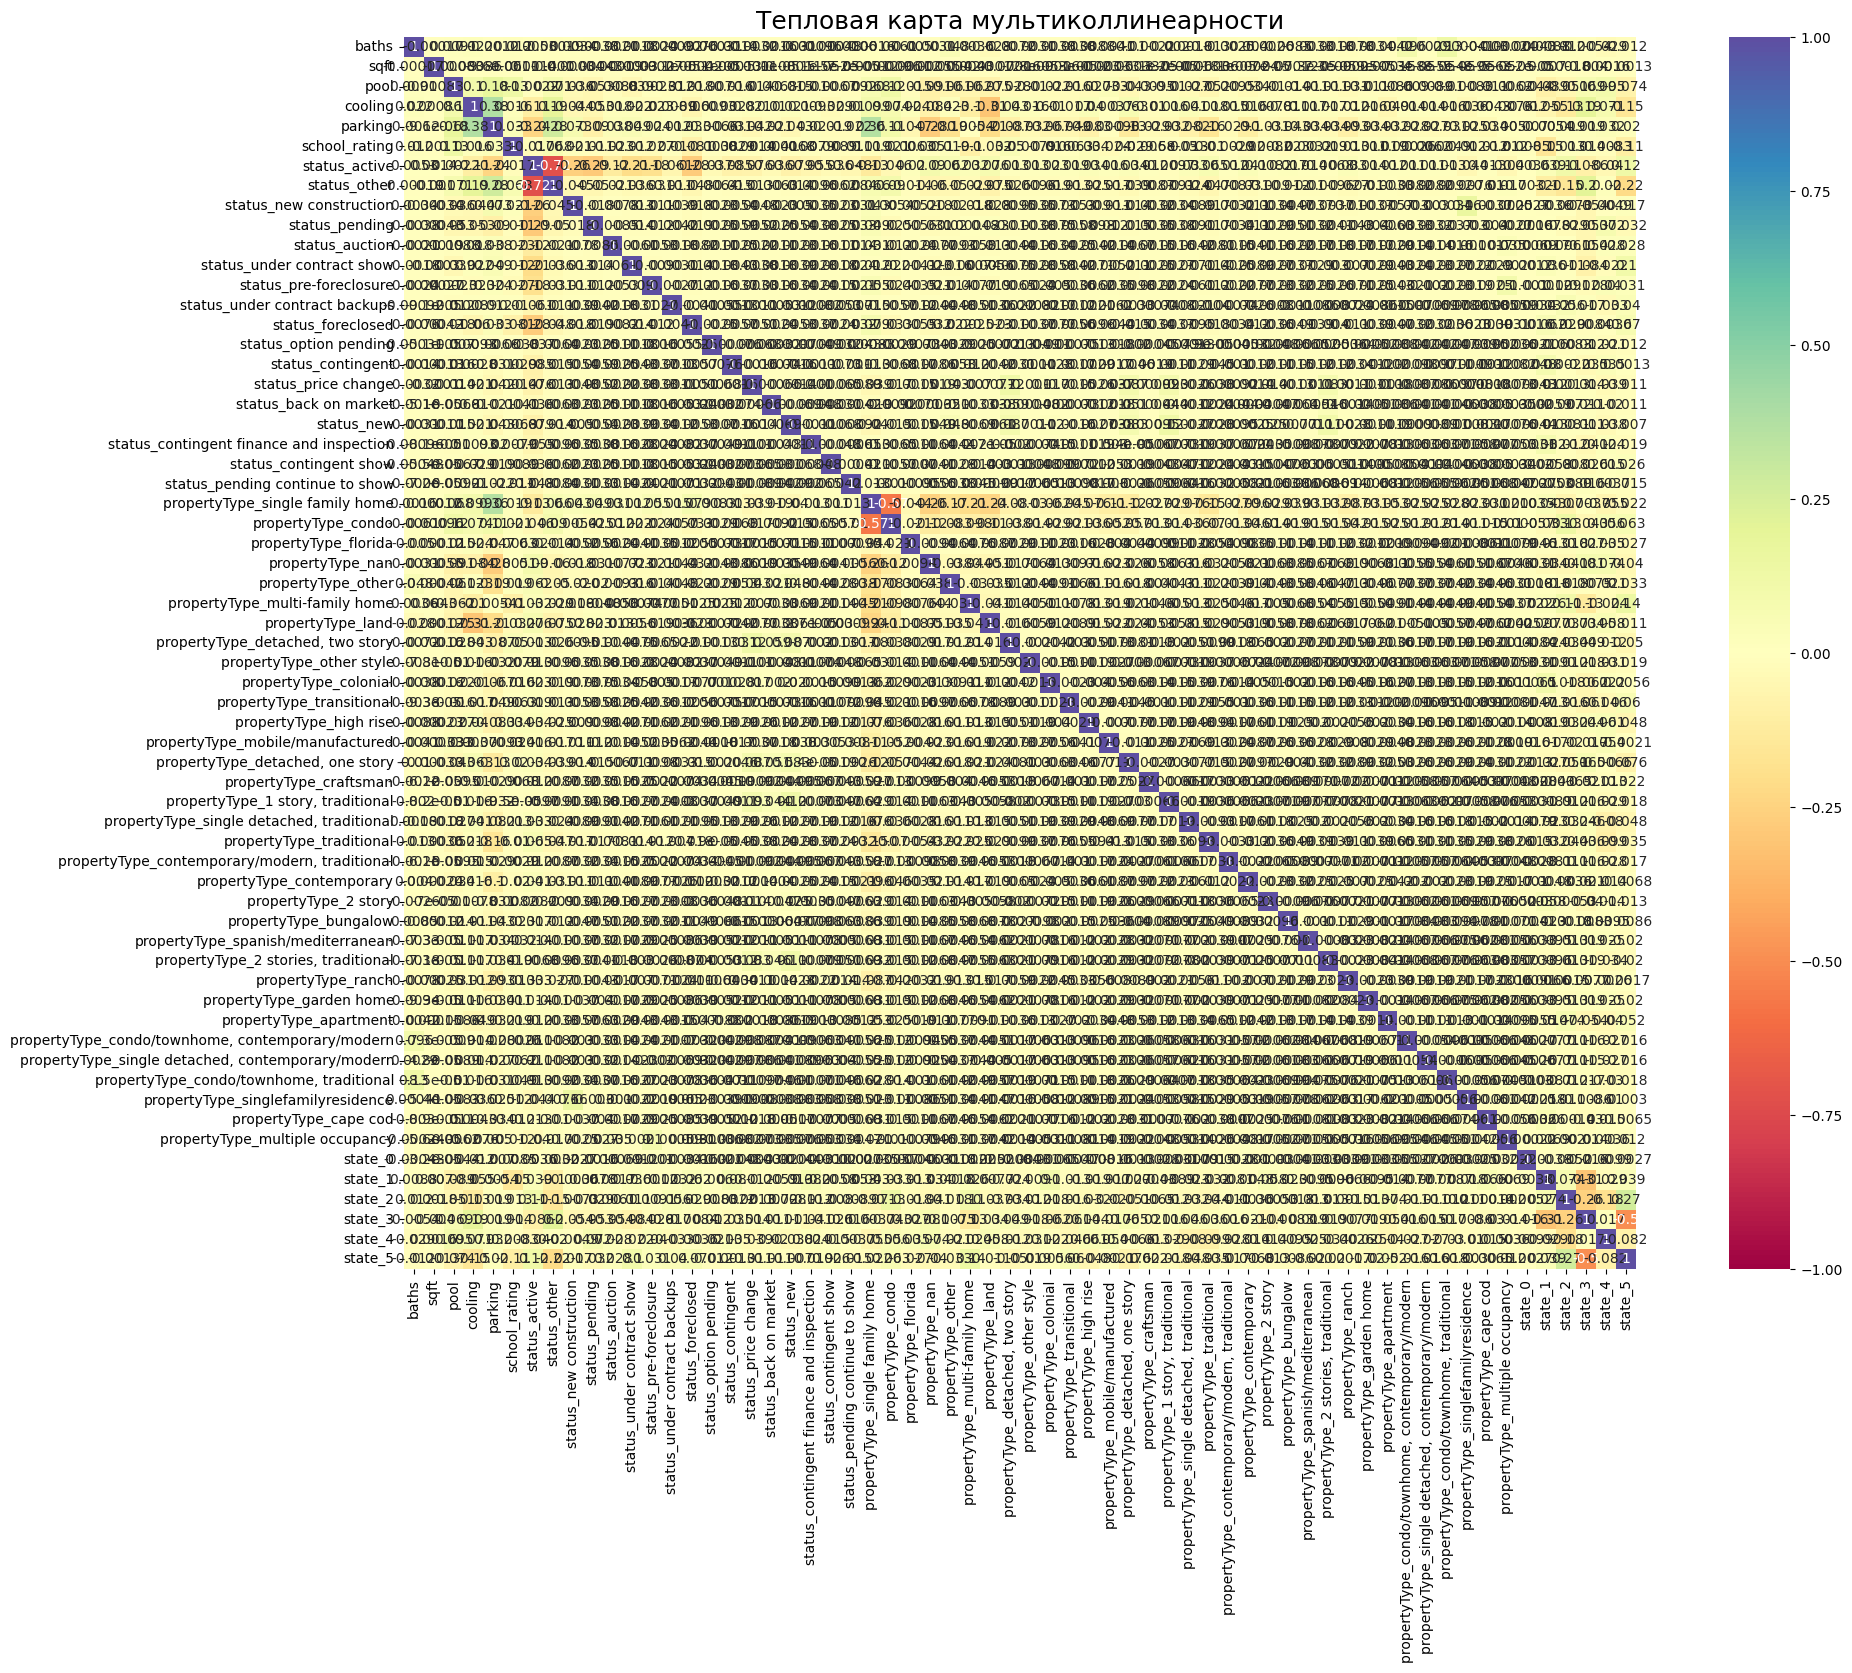

In [301]:
#построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = clean.drop('target', axis=1).corr(method='pearson'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Вывод: Считаем, что мультиколлинеарность отсутствует, корреляция ниже 0.9

Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую

In [302]:
X = clean.drop(['target'], axis=1)
y = clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)
#проверяем размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(231441, 62) (99189, 62) (231441,) (99189,)


In [303]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330630 entries, 0 to 330629
Data columns (total 63 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   baths                                              330630 non-null  float64
 1   sqft                                               330630 non-null  float64
 2   target                                             330630 non-null  int64  
 3   pool                                               330630 non-null  int64  
 4   cooling                                            330630 non-null  int64  
 5   parking                                            330630 non-null  int64  
 6   school_rating                                      330630 non-null  float64
 7   status_active                                      330630 non-null  int64  
 8   status_other                                       330630 non-null  int64 

Отберем наиболее важные признаки, которые сильнее всего связаны с целевой переменной

In [305]:
#отберем с помощью SelectKBest 20 наиболее подходящих признаков
selector = SelectKBest(score_func=f_regression, k=20)
selector.fit(X_train, y_train)

cols = selector.get_feature_names_out()
print(cols)

['baths' 'sqft' 'pool' 'cooling' 'parking' 'school_rating' 'status_active'
 'status_pre-foreclosure' 'status_foreclosed'
 'propertyType_single family home' 'propertyType_condo'
 'propertyType_other' 'propertyType_multi-family home' 'propertyType_land'
 'propertyType_detached, two story' 'propertyType_mobile/manufactured'
 'state_1' 'state_2' 'state_3' 'state_5']


In [306]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330630 entries, 0 to 330629
Data columns (total 63 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   baths                                              330630 non-null  float64
 1   sqft                                               330630 non-null  float64
 2   target                                             330630 non-null  int64  
 3   pool                                               330630 non-null  int64  
 4   cooling                                            330630 non-null  int64  
 5   parking                                            330630 non-null  int64  
 6   school_rating                                      330630 non-null  float64
 7   status_active                                      330630 non-null  int64  
 8   status_other                                       330630 non-null  int64 

`Нормализация данных`

Для наглядности построим визуализацию распределения данных до нормализации.

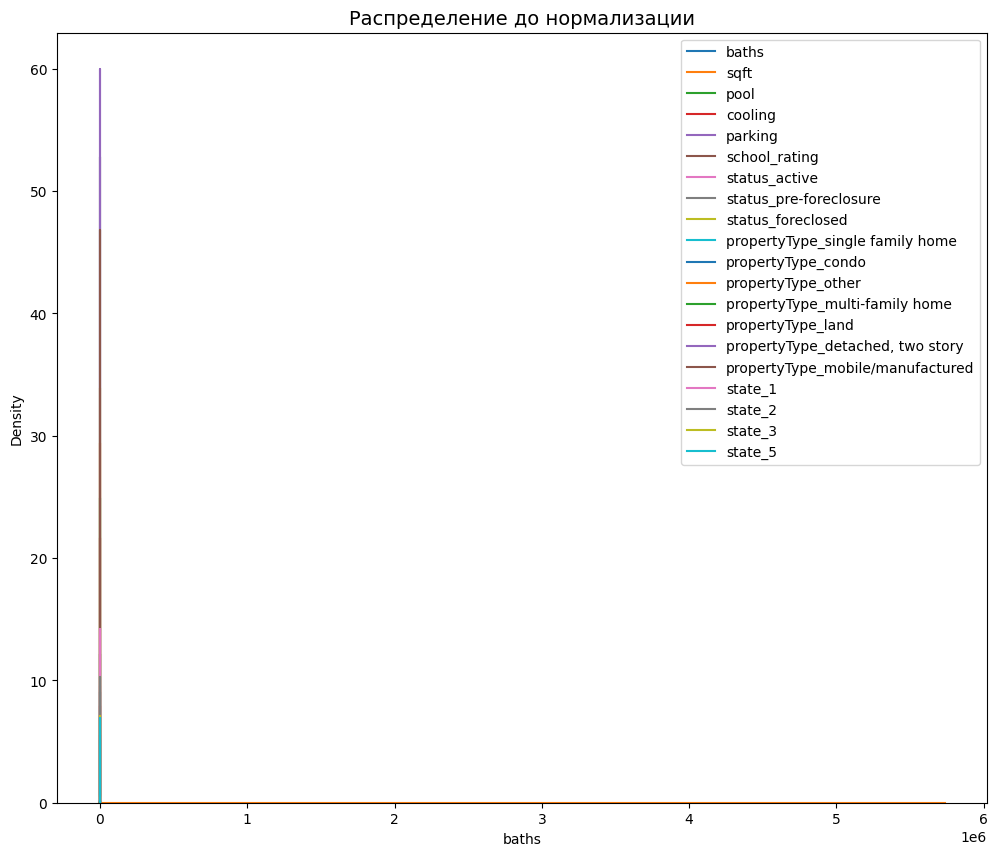

In [310]:
#визуализируем кривые распределения:
fig, ax = plt.subplots(ncols=1, figsize=(12, 10))
ax.set_title('Распределение до нормализации', fontsize=14)

for col in cols:
    sns.kdeplot(X_train[col], ax=ax, label=col)
plt.legend();

In [311]:
#зададим нормализатор MinMaxScaler
scaler = MinMaxScaler()
#вычисляем параметры для нормализации: min и max для каждого столбца
scaler.fit(X_train[cols])
#произведем преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train[cols])
X_test_scaled = scaler.transform(X_test[cols])

#датасет для визуализации, промежуточный
df_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)

 Визуализация после применения нормализации

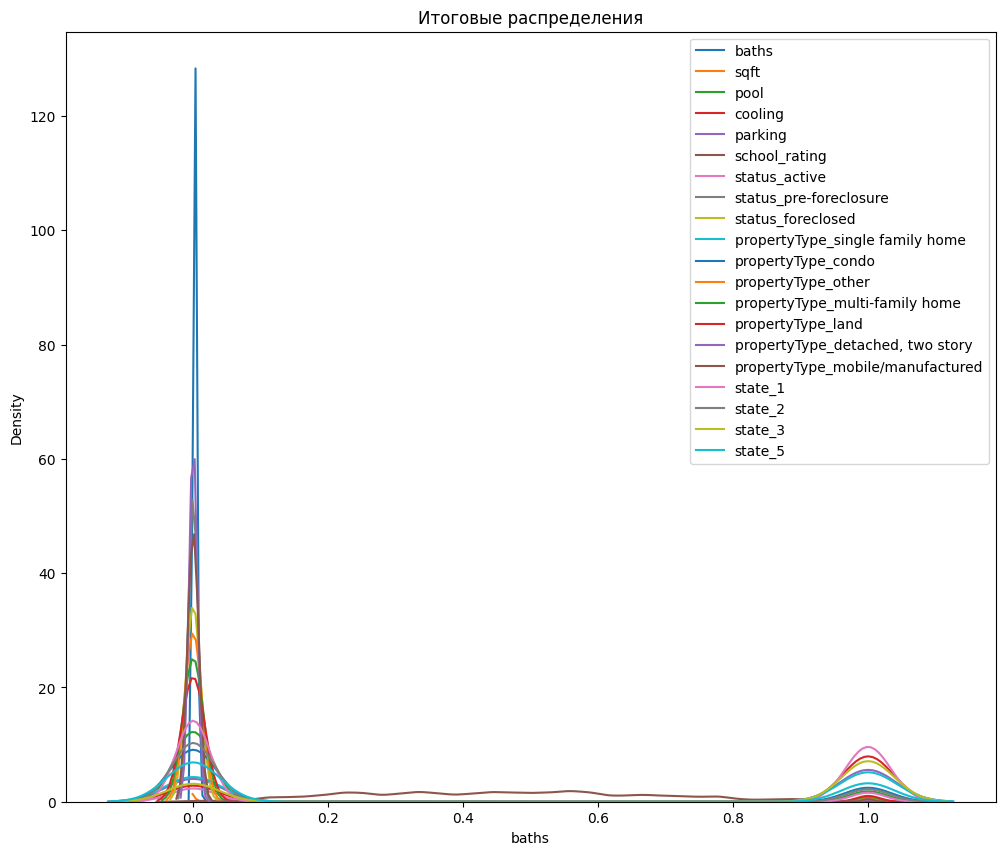

In [312]:
#визуализируем кривые распределения
fig, ax = plt.subplots(ncols=1, figsize=(12, 10))
ax.set_title('Распределения после нормализации')

for col in cols:
    sns.kdeplot(df_train_scaled[col], ax=ax, label=col)
plt.legend();

### Построение модели  

In [313]:
#cоздадим функцию для расчета метрик
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

`Baseline модель`

In [323]:
# тренировочный и тестовый набор для базовой модели
X_train_base = X_train[['sqft', 'school_rating', 'baths']]
X_test_base = X_test[['sqft', 'school_rating', 'baths']]

In [324]:
# Вычисляем параметры для нормализации:
scaler.fit(X_train_base)
# Производим преобразование для каждой из выборок
X_train_base_scaled = scaler.transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

In [325]:
# обучаем линейную регрессию и рассчитываем метрики качества
lr = linear_model.LinearRegression()
lr.fit(X_train_base_scaled, y_train)
y_pred_train = lr.predict(X_train_base_scaled)
y_pred_test = lr.predict(X_test_base_scaled)
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train R^2: 0.027
Train MAE: 506627.379
Train MAPE: 2208.580


Test R^2: -20.904
Test MAE: 555385.788
Train MAPE: 2369.795


Базовая модель показала плохие результаты. Отрицательный коэффициент $R^{2}=-20.904$ на тестовой выборке показывает, что модели не уловила разнообразия в данных.

`LinearRegression`

In [326]:
#обучаем линейную регрессию и рассчитываем метрики качества
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train R^2: 0.065
Train MAE: 488766.761
Train MAPE: 1655.236


Test R^2: -13.980
Test MAE: 530781.797
Train MAPE: 1921.675


Модель, обученная на всех признаках, улучшила метрики базовой модели, но незначительно.

`SGD Regressor`

In [327]:
#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.063
Train MAE: 510259.492
Train MAPE: 1730.871


Test R^2: 0.050
Test MAE: 523545.723
Train MAPE: 1989.794


SGD Regressor  намного улучшил метрику MAE предыдущей модели.

`DecisionTreeRegressor`

Найдем глубину дерева, для которой будет максимальное значение метрики, но при этом ещё не будет наблюдаться переобучения

In [328]:
#задаем параметры для дерева
max_depth = range(7,25)
mse_train_list = []
mse_test_list = []
for depth in max_depth:
    dt = tree.DecisionTreeRegressor(random_state=42, max_depth=depth)
    dt.fit(X_train_scaled, y_train)
    y_pred_train = dt.predict(X_train_scaled)
    y_pred_valid = dt.predict(X_test_scaled)
    mse_train = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
    mse_train_list.append(mse_train)
    mse_valid = metrics.mean_squared_error(y_test, y_pred_valid, squared=False)
    mse_test_list.append(mse_valid)

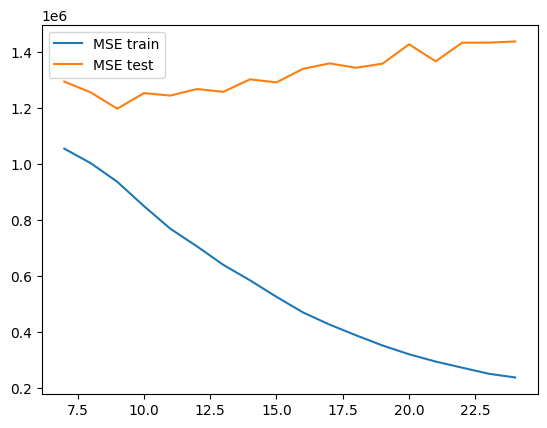

In [329]:
#построим графики
sns.lineplot(x=max_depth, y=mse_train_list, label='MSE train')
sns.lineplot(x=max_depth, y=mse_test_list, label='MSE test')
ax.set_title('Зависимость метрики MSE от глубины дерева решений')
ax.legend();

In [333]:
#обучаем решающие деревья глубиной 9
dtc = tree.DecisionTreeRegressor(max_depth=9, random_state=42)
dtc.fit(X_train_scaled, y_train)
y_test_pred = dtc.predict(X_test_scaled)
y_train_pred = dtc.predict(X_train_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.650
Train MAE: 307722.390
Train MAPE: 1545.899


Test R^2: 0.544
Test MAE: 332741.216
Train MAPE: 929.109


Модель показала хорошие результаты. Коэффициент детерминации $R^{2}$ на тестовой поднялся из - и сейчас  0,544.  
Небольшая разница между результатами на тернировочном и тестовом наборе данных говорит об отсутствии переобучения.  


`RandomForestRegressor`

In [334]:
#обучим модель с произвольными параметрами
model = RandomForestRegressor(n_estimators=50,
                           max_depth=12,
                           criterion='squared_error',
                           min_samples_split=20,
                           random_state=42)
#бучаем модель на тестовом наборе данных
model.fit(X_train_scaled, y_train)

#bспользуем обученную модель для предсказания в тестовой выборке.
#gредсказанные значения записываем в переменную y_pred
#lлаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.675
Train MAE: 278410.182
Train MAPE: 1451.782


Test R^2: 0.591
Test MAE: 304484.204
Train MAPE: 1094.336


Модель показывает плохие результаты, ошибка *MAPE* на тестовом наборе данных 1094.336.

`GradientBoostingRegressor`

In [335]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.5,
                               n_estimators=50,
                               max_depth=12,
                               min_samples_split=20,
                               random_state=42,
                               verbose=True)
# обучение модели
gb.fit(X_train_scaled, y_train)
# предсказание на тренировочной и валидационной выборках
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

      Iter       Train Loss   Remaining Time 
         1 1210606342336.4346            3.06m
         2 792970760424.9525            2.87m
         3 640668399759.2366            2.40m
         4 531020482051.7017            2.17m
         5 465699709717.3445            2.07m
         6 429363231033.3649            1.94m
         7 408556963504.4448            1.85m
         8 396215283395.3351            1.80m
         9 376159639920.8894            1.73m
        10 367061970797.1099            1.68m
        20 304697397280.5209            1.06m
        30 266904601494.2585           42.44s
        40 234028711339.5607           20.23s
        50 211872474972.6868            0.00s
Train R^2: 0.916
Train MAE: 207312.029
Train MAPE: 974.646


Test R^2: 0.573
Test MAE: 304445.171
Train MAPE: 1023.535


*GradientBoostingRegressor* с произвольными параметрами не удалось улучшить метрику предыдущей модели на тестовой выборке 


Выполним подбор гипрепараметров *RandomForestRegressor* с помощью *optuna*

In [337]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.r2_score(y_train, model.predict(X_train_scaled))

  return score

In [338]:
%%time
#cоздаем объект исследования
#можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
#ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-11-05 21:55:39,232] A new study created in memory with name: RandomForestRegressor
[I 2023-11-05 21:58:20,006] Trial 0 finished with value: 0.7146439384609351 and parameters: {'n_estimators': 108, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7146439384609351.
[I 2023-11-05 22:00:37,700] Trial 1 finished with value: 0.6277564942245346 and parameters: {'n_estimators': 121, 'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7146439384609351.
[I 2023-11-05 22:03:23,650] Trial 2 finished with value: 0.6409834882819101 and parameters: {'n_estimators': 173, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7146439384609351.
[I 2023-11-05 22:05:51,752] Trial 3 finished with value: 0.6545942616220384 and parameters: {'n_estimators': 156, 'max_depth': 11, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7146439384609351.
[I 2023-11-05 22:09:47,536] Trial 4 finished with value: 0.7419049449871367 and parameters: {'n_

CPU times: total: 28min 21s
Wall time: 36min 31s


In [339]:
#выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 186, 'max_depth': 18, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.74


In [340]:
#построим модель с лучшими гиперпараметрами и рассчитаем метрики
model = ensemble.RandomForestRegressor(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 231144.629
Train MAPE: 1046.760


Test R^2: 0.617
Test MAE: 288989.130
Train MAPE: 1170.938


In [341]:
# итоговые результаты
dict_metrics = {
        'Model': [
                'Baseline',
                'LinearRegression',
                'SGDRegressor',
                'DTRegressor',
                'RFRegressor',
                'GBRegressor',
                'RFRegressor(optuna)'
                ],
        'Test R^2': [0.802, 0.808, 0.808, 0.999, 0.999, 1, 1],
        'Test MAPE':[53.628, 50.593, 49.664, 2.082, 0.784, 0.787, 0.724]}

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

Model  Test R^2  Test MAPE
0             Baseline     0.802     53.628
1     LinearRegression     0.808     50.593
2         SGDRegressor     0.808     49.664
3          DTRegressor     0.999      2.082
4          RFRegressor     0.999      0.784
5          GBRegressor     1.000      0.787
6  RFRegressor(optuna)     1.000      0.724

In [344]:
#сохранение модели
with open('model.pkl', 'wb') as output:
       pickle.dump(model, output)

Итоги проекта.
* Датасет очищен от мусора, дубликатов, пропущенных значений и выбросов.
* Созданы новые переменные.
* Произведен отбор признаков различными методами.
* Построина модель при помощи LinearRegression
* Построина модель на основе случайного леса RandomForestRegressor.
* Построина модель градиентного бустинга GradientBoostingRegressor.